<a href="https://colab.research.google.com/github/Andrew-WongLH/ucl-pred-analytics-air-traffic/blob/main/pred_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Airport Traffic in European Countries

MSIN0097 Predictive Analytics: Individual Coursework

March 2025

In [4]:
# setup
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# TensorFlow / Keras for NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid")

# 2. DATA PREPARATION

In [5]:
# load data from source files
"""
We assume each CSV file has a consistent structure:
YEAR, MONTH_NUM, FLT_DATE, APT_ICAO, APT_NAME, STATE_NAME,
FLT_DEP_1, FLT_ARR_1, FLT_TOT_1, ...
"""
from google.colab import drive
drive.mount('/content/drive')

data_frames = []
data_path = "/content/drive/My Drive/Colab Notebooks/pred_analytics_data/"  # <-- Update with actual path

# data_path = "data/" <-- use this for github datasets

for year in range(2016, 2025):
    csv_file = os.path.join(data_path, f"airport_traffic_{year}.csv")
    if os.path.exists(csv_file):
        temp = pd.read_csv(csv_file, parse_dates=["FLT_DATE"], dayfirst=True)
        data_frames.append(temp)
    else:
        print(f"Warning: File not found for {year}, skipping.")

# Merge all into one DataFrame
df_raw = pd.concat(data_frames, ignore_index=True)

# keep date format
df_raw['FLT_DATE'] = pd.to_datetime(
    df_raw['FLT_DATE'],
    format='%d-%m-%y'  # Explicitly match DD-MM-YY
)

# Let's see the structure
print("Data shape:", df_raw.shape)
df_raw.head()

Mounted at /content/drive
Data shape: (983842, 13)


YEAR  MONTH_NUM MONTH_MON   FLT_DATE APT_ICAO    APT_NAME STATE_NAME  \
0  2016          1       JAN 2016-01-01     LATI      Tirana    Albania   
1  2016          1       JAN 2016-01-01     UDYZ     Yerevan    Armenia   
2  2016          1       JAN 2016-01-01     LOWG        Graz    Austria   
3  2016          1       JAN 2016-01-01     LOWI   Innsbruck    Austria   
4  2016          1       JAN 2016-01-01     LOWK  Klagenfurt    Austria   

   FLT_DEP_1  FLT_ARR_1  FLT_TOT_1  FLT_DEP_IFR_2  FLT_ARR_IFR_2  \
0         24         27         51            NaN            NaN   
1          8         15         23            NaN            NaN   
2          6          7         13            NaN            NaN   
3         26         32         58            NaN            NaN   
4          3          4          7            NaN            NaN   

   FLT_TOT_IFR_2  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [3]:
# Basic stats
print(df_raw.info())
print(df_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983842 entries, 0 to 983841
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   YEAR           983842 non-null  int64         
 1   MONTH_NUM      983842 non-null  int64         
 2   MONTH_MON      983842 non-null  object        
 3   FLT_DATE       983842 non-null  datetime64[ns]
 4   APT_ICAO       983842 non-null  object        
 5   APT_NAME       983842 non-null  object        
 6   STATE_NAME     983842 non-null  object        
 7   FLT_DEP_1      983842 non-null  int64         
 8   FLT_ARR_1      983842 non-null  int64         
 9   FLT_TOT_1      983842 non-null  int64         
 10  FLT_DEP_IFR_2  292851 non-null  float64       
 11  FLT_ARR_IFR_2  292851 non-null  float64       
 12  FLT_TOT_IFR_2  292851 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 97.6+ MB
None
                YEAR  

In [4]:
# Check for missing values
missing_counts = df_raw.isna().sum()
print("Missing value counts:\n", missing_counts)

Missing value counts:
 YEAR                  0
MONTH_NUM             0
MONTH_MON             0
FLT_DATE              0
APT_ICAO              0
APT_NAME              0
STATE_NAME            0
FLT_DEP_1             0
FLT_ARR_1             0
FLT_TOT_1             0
FLT_DEP_IFR_2    690991
FLT_ARR_IFR_2    690991
FLT_TOT_IFR_2    690991
dtype: int64


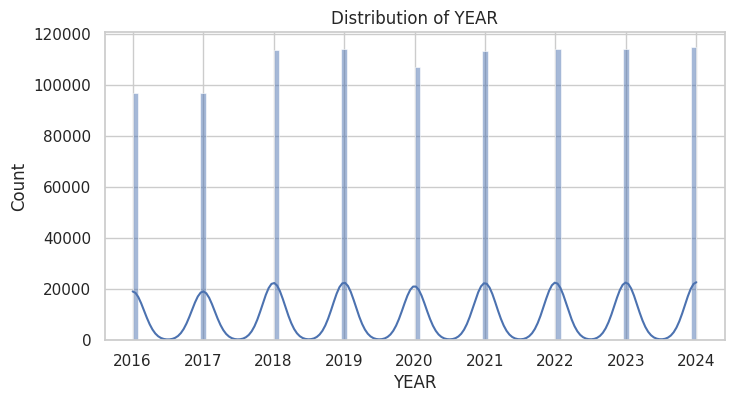

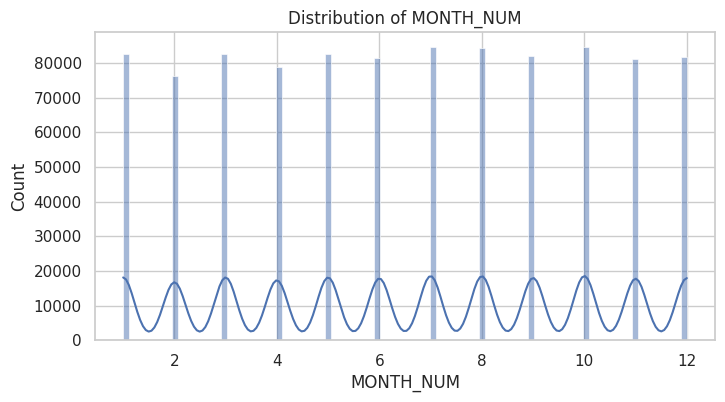

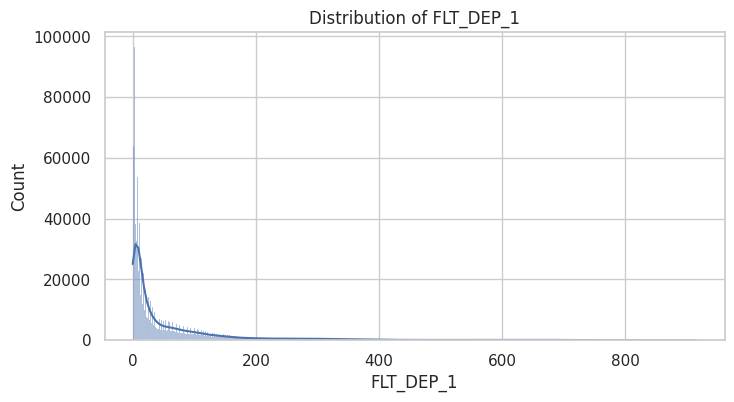

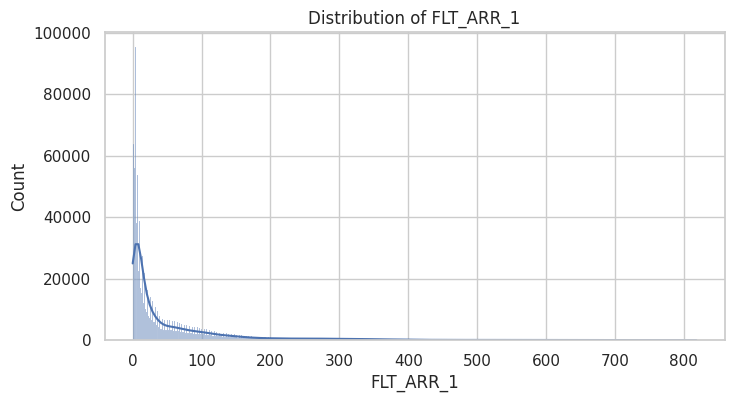

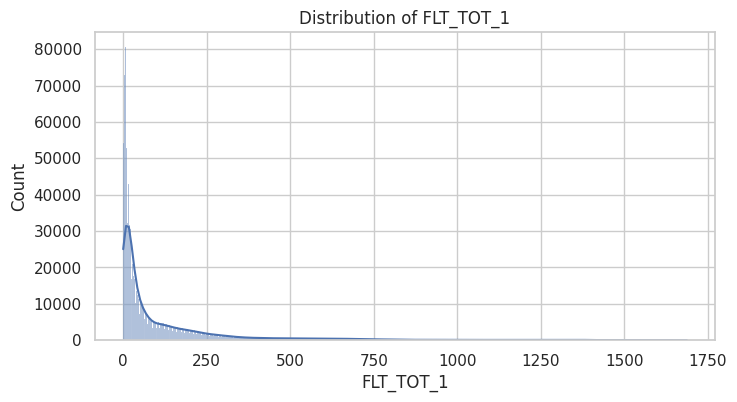

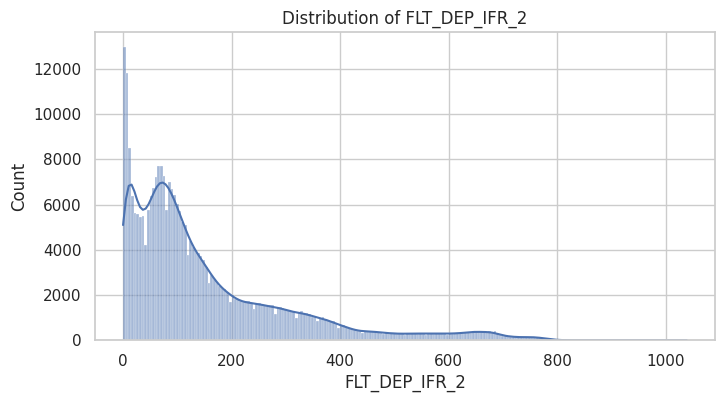

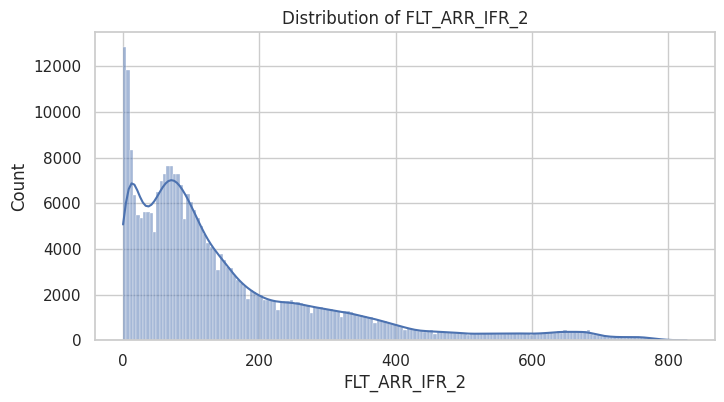

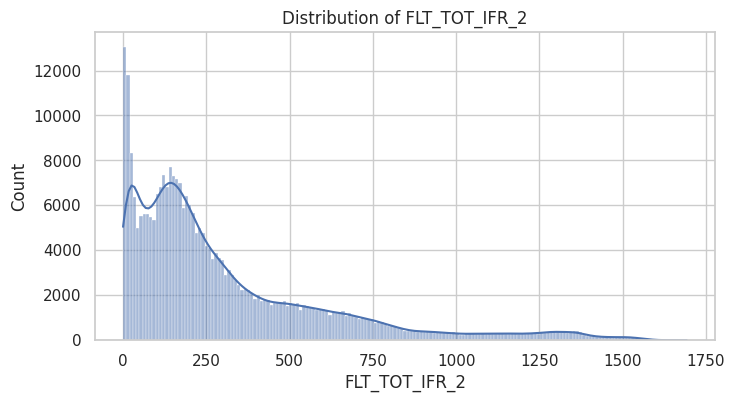

In [5]:
# distribution of variables
numeric_cols = df_raw.select_dtypes(include=np.number).columns.tolist()

# Plot distribution for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_raw, x=col, kde=True)  # kde=True adds a kernel density estimate
    plt.title(f'Distribution of {col}')
    plt.show()

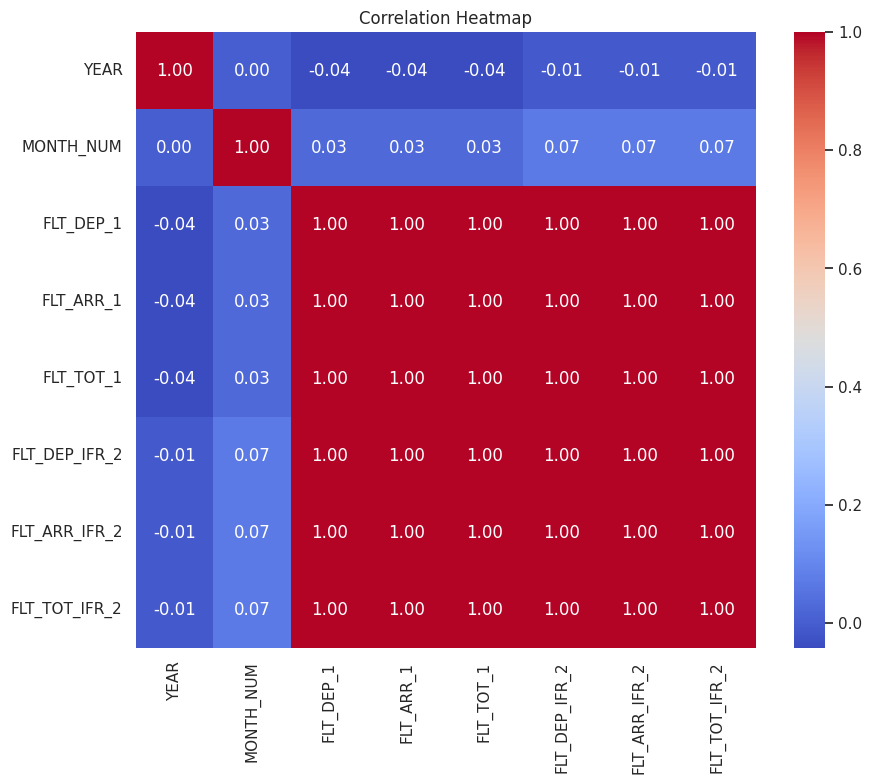

In [6]:
# Compute correlation matrix
corr_matrix = df_raw[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [6]:
# Quick cleaning
df_cleaned = df_raw.copy()

# Remove unnecessary columns
df_cleaned.drop('FLT_DEP_IFR_2', axis=1, inplace=True)
df_cleaned.drop('FLT_ARR_IFR_2', axis=1, inplace=True)
df_cleaned.drop('FLT_TOT_IFR_2', axis=1, inplace=True)
df_cleaned.drop('MONTH_MON', axis=1, inplace=True)

# rename daily total
df_cleaned.rename(columns={
    'FLT_TOT_1':'DailyFlights'
}, inplace=True)

df_cleaned.sort_values(by=['APT_ICAO','FLT_DATE'], inplace=True)
df_cleaned.head() #note: BIKF data starts from 2024, others should be from 2016-01-01

YEAR  MONTH_NUM   FLT_DATE APT_ICAO  APT_NAME STATE_NAME  FLT_DEP_1  \
869189  2024          1 2024-01-01     BIKF  Keflavik    Iceland         76   
869486  2024          1 2024-01-02     BIKF  Keflavik    Iceland         86   
869792  2024          1 2024-01-03     BIKF  Keflavik    Iceland         81   
870100  2024          1 2024-01-04     BIKF  Keflavik    Iceland         75   
870412  2024          1 2024-01-05     BIKF  Keflavik    Iceland         84   

        FLT_ARR_1  DailyFlights  
869189         62           138  
869486         86           172  
869792         78           159  
870100         79           154  
870412         79           163

# 3. EXPLORATORY DATA ANALYSIS

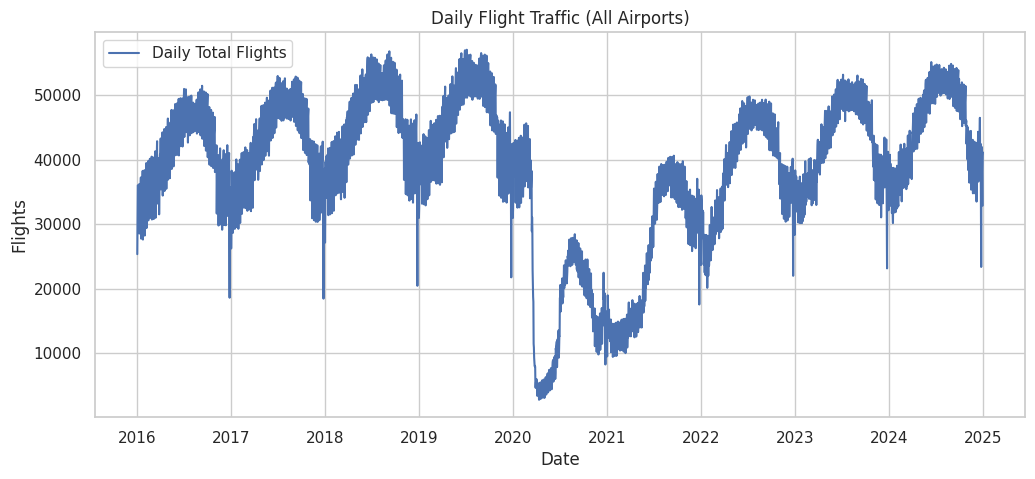

In [8]:
# Visualizing overall traffic across time
daily_traffic = df_cleaned.groupby("FLT_DATE")["DailyFlights"].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(daily_traffic["FLT_DATE"], daily_traffic["DailyFlights"], label="Daily Total Flights")
plt.title("Daily Flight Traffic (All Airports)")
plt.xlabel("Date")
plt.ylabel("Flights")
plt.legend()
plt.show()


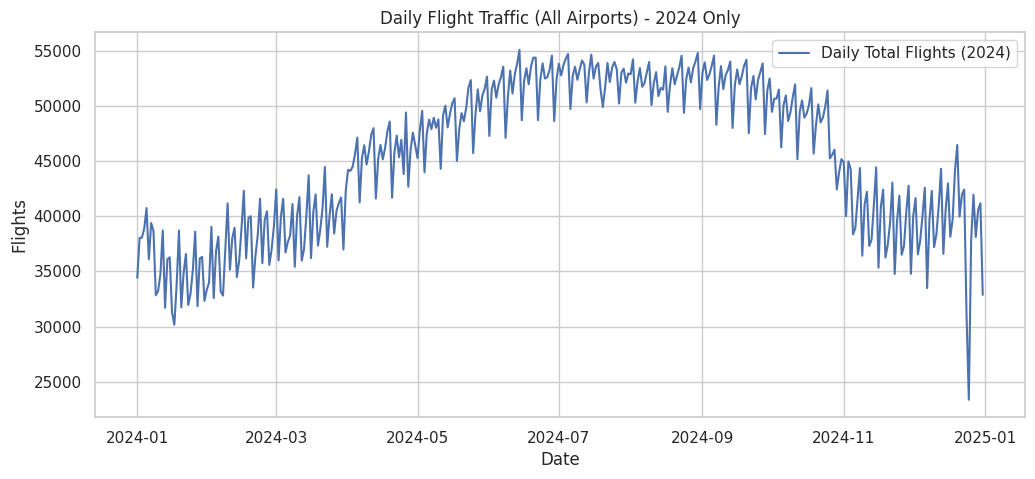

In [9]:
# 1. Filter df for rows where FLT_DATE is in 2024
df_2024 = df_cleaned[df_cleaned['FLT_DATE'].dt.year == 2024]

# 2. Aggregate total flights by FLT_DATE for 2024
daily_traffic_2024 = df_2024.groupby("FLT_DATE")["DailyFlights"].sum().reset_index()

# 3. Plot
plt.figure(figsize=(12,5))
plt.plot(daily_traffic_2024["FLT_DATE"], daily_traffic_2024["DailyFlights"], label="Daily Total Flights (2024)")
plt.title("Daily Flight Traffic (All Airports) - 2024 Only")
plt.xlabel("Date")
plt.ylabel("Flights")
plt.legend()
plt.show()


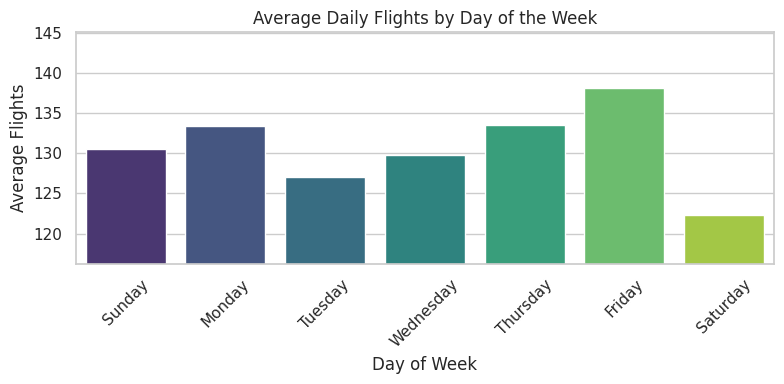

In [10]:
# day of week
# 1. Ensure FLT_DATE is a proper datetime
df_cleaned['FLT_DATE'] = pd.to_datetime(df_cleaned['FLT_DATE'], dayfirst=True)

# 2. Extract the day name
df_cleaned['DAY_OF_WEEK'] = df_cleaned['FLT_DATE'].dt.day_name()

# 3. Compute the AVERAGE flights per day of week
#    (Replace 'DailyFlights' with the name of your flights column)
days_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df_by_dow = (
    df_cleaned
    .groupby('DAY_OF_WEEK')['DailyFlights']
    .mean()
    .reindex(days_order)
)

# 4. Create the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=df_by_dow.index, y=df_by_dow.values, palette='viridis')

plt.title('Average Daily Flights by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Flights')

# 5. Zoom in the y-axis to show only the "top" of each bar:
min_val, max_val = df_by_dow.min(), df_by_dow.max()
# Adjust the range to exaggerate differences:
plt.ylim(min_val * 0.95, max_val * 1.05)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


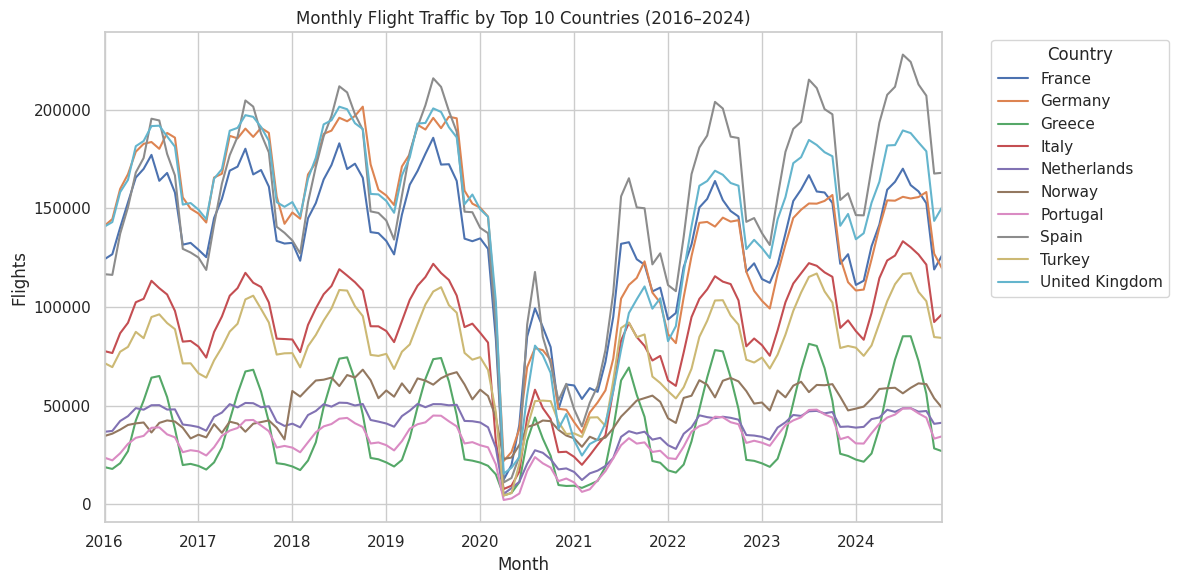

In [11]:
# monthly total by country for 2016-2024, each country each line

# 1) (Optional) Filter for 2016–2024
df_16_24 = df_cleaned[
    (df_cleaned['FLT_DATE'].dt.year >= 2016) &
    (df_cleaned['FLT_DATE'].dt.year <= 2024)
].copy()

# 2) Create a "Year-Month" column so we can group by month
df_16_24['YearMonth'] = df_16_24['FLT_DATE'].dt.to_period('M')

# 3) Sum flights by (YearMonth, COUNTRY)
monthly_by_country = (
    df_16_24
    .groupby(['YearMonth', 'STATE_NAME'])['DailyFlights']
    .sum()
    .reset_index()
)

# 4) Find the top 10 countries by TOTAL flights across the time span
country_totals = monthly_by_country.groupby('STATE_NAME')['DailyFlights'].sum()
top_10_countries = country_totals.nlargest(10).index

# 5) Filter the monthly data for top 10 countries
monthly_top_10 = monthly_by_country[monthly_by_country['STATE_NAME'].isin(top_10_countries)]

# 6) Pivot so each of the top 10 countries is a column, and each row is a month
pivot_top_10 = monthly_top_10.pivot(
    index='YearMonth',
    columns='STATE_NAME',
    values='DailyFlights'
).fillna(0)

# 7) Convert 'YearMonth' (Period) index to a proper DateTimeIndex (for easier plotting)
pivot_top_10.index = pivot_top_10.index.to_timestamp()

# 8) Plot the monthly flights for the top 10 countries
plt.figure(figsize=(12,6))
pivot_top_10.plot(ax=plt.gca())
plt.title('Monthly Flight Traffic by Top 10 Countries (2016–2024)')
plt.xlabel('Month')
plt.ylabel('Flights')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



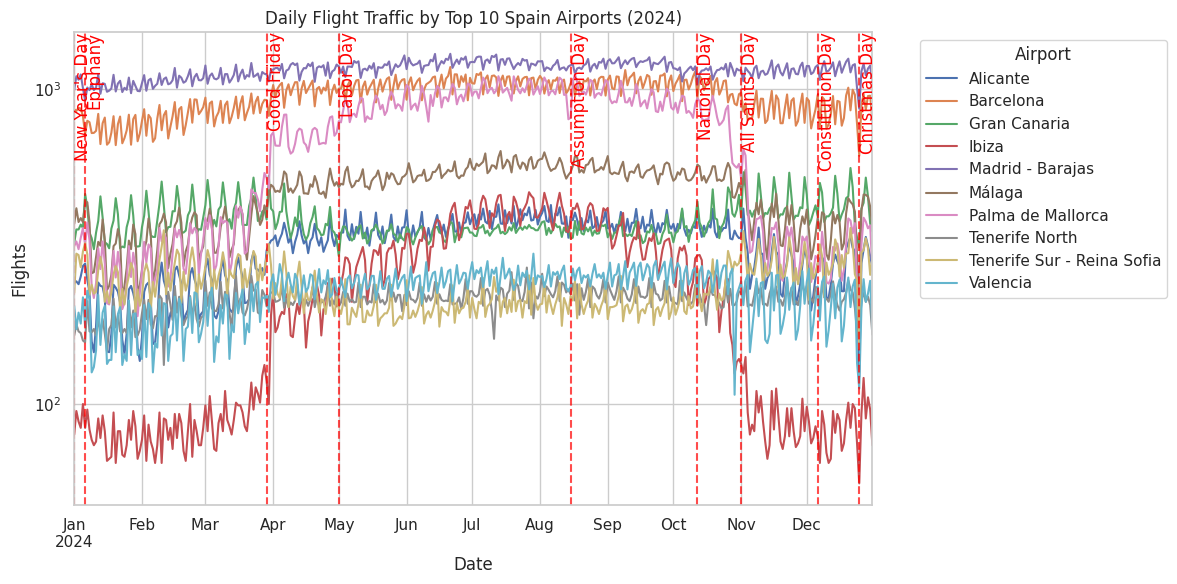

In [12]:
# daily total by top 10 airports in spain for 2024, with spain holidays labelled, each airport each line (use airport name for labels)

import holidays

# 1) Create Spain holiday object for 2024
spain_holidays_2024 = holidays.Spain(years=[2024])

# 2) Filter DataFrame for Spain flights in 2024
df_spain_2024 = df_cleaned[
    (df_cleaned['STATE_NAME'] == 'Spain') &
    (df_cleaned['FLT_DATE'].dt.year == 2024)
].copy()

# 3) Identify the top 10 airports by total flights in 2024
total_by_airport = df_spain_2024.groupby('APT_NAME')['DailyFlights'].sum()
top_10_airports = total_by_airport.nlargest(10).index

# Filter to only include data from the top 10 airports
df_spain_top10_2024 = df_spain_2024[df_spain_2024['APT_NAME'].isin(top_10_airports)]

# 4) Group by date and airport to compute daily totals
daily_by_airport_spain_2024 = (
    df_spain_top10_2024
    .groupby(['FLT_DATE','APT_NAME'])['DailyFlights']
    .sum()
    .reset_index()
)

# 5) Pivot the data so that each airport is its own column
pivot_spain_2024_daily = daily_by_airport_spain_2024.pivot(
    index='FLT_DATE',
    columns='APT_NAME',
    values='DailyFlights'
).fillna(0)

# 6) Plot each airport's daily flights with log scale on the y-axis
plt.figure(figsize=(12,6))
pivot_spain_2024_daily.plot(ax=plt.gca())

plt.title('Daily Flight Traffic by Top 10 Spain Airports (2024)')
plt.xlabel('Date')
plt.ylabel('Flights')
plt.yscale('log')  # Use a log scale to improve visibility of smaller values
plt.legend(title='Airport', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# 7) Annotate Spain holidays on the plot
for holiday_date, holiday_name in spain_holidays_2024.items():
    holiday_ts = pd.to_datetime(holiday_date)
    if holiday_ts.year == 2024:
        plt.axvline(x=holiday_ts, color='red', linestyle='--', alpha=0.7)
        ymax = plt.ylim()[1]
        plt.text(
            x=holiday_ts,
            y=ymax,
            s=holiday_name,
            color='red',
            rotation=90,
            verticalalignment='top'
        )

plt.show()






In [7]:
print("Data shape:", df_cleaned.shape)
df_cleaned.head()

Data shape: (983842, 9)


YEAR  MONTH_NUM   FLT_DATE APT_ICAO  APT_NAME STATE_NAME  FLT_DEP_1  \
869189  2024          1 2024-01-01     BIKF  Keflavik    Iceland         76   
869486  2024          1 2024-01-02     BIKF  Keflavik    Iceland         86   
869792  2024          1 2024-01-03     BIKF  Keflavik    Iceland         81   
870100  2024          1 2024-01-04     BIKF  Keflavik    Iceland         75   
870412  2024          1 2024-01-05     BIKF  Keflavik    Iceland         84   

        FLT_ARR_1  DailyFlights  
869189         62           138  
869486         86           172  
869792         78           159  
870100         79           154  
870412         79           163

# 4. FEATURE ENGINEERING

In [7]:
# 1) START WITH A CLEAN DATAFRAME
df_featured = df_cleaned.copy()
df_featured.sort_values(by=['APT_ICAO','FLT_DATE'], inplace=True)

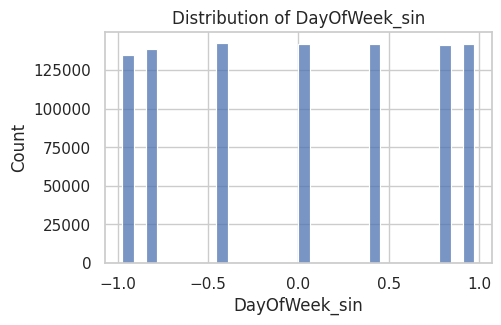

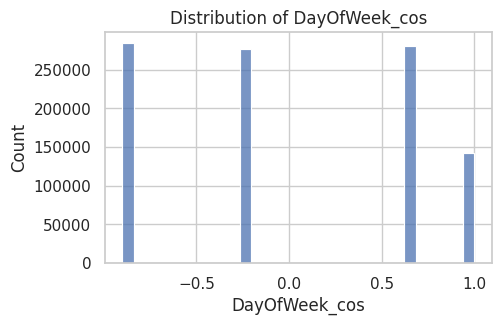

In [8]:
# 1. DAY-OF-WEEK AS A CYCLICAL FEATURE
# Instead of DOW_0..DOW_6, we use sine/cosine transform:
# day_of_week_sin = sin(2π * DayOfWeek / 7)
# day_of_week_cos = cos(2π * DayOfWeek / 7)
# This better preserves cyclical continuity (Sunday -> Monday).

df_featured['Day'] = df_featured['FLT_DATE'].dt.day

df_featured['DayOfWeek'] = df_featured['FLT_DATE'].dt.dayofweek  # Monday=0, Sunday=6
df_featured['DayOfWeek_sin'] = np.sin(2 * np.pi * df_featured['DayOfWeek'] / 7)
df_featured['DayOfWeek_cos'] = np.cos(2 * np.pi * df_featured['DayOfWeek'] / 7)

# Distribution check:
plt.figure(figsize=(5,3))
sns.histplot(df_featured['DayOfWeek_sin'], bins=30)
plt.title("Distribution of DayOfWeek_sin")
plt.show()

plt.figure(figsize=(5,3))
sns.histplot(df_featured['DayOfWeek_cos'], bins=30)
plt.title("Distribution of DayOfWeek_cos")
plt.show()



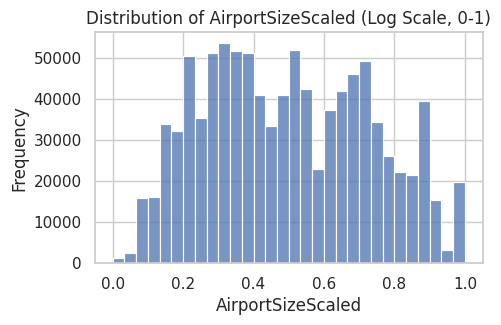

In [9]:
# 2. AIRPORT SIZE (SCALED 0–1 INSTEAD OF BINARY)
# We'll define 'AvgFlights2019' as a measure of airport size.
# Then scale it to [0,1] across all airports.
#   scale = (value - min) / (max - min)
# If an airport doesn't appear in 2019 data, we can set it to median.

# 2.1 Compute average 2019 flights per airport
df_2019 = df_featured[df_featured['FLT_DATE'].dt.year == 2019]
airport_avg_2019 = df_2019.groupby('APT_ICAO')['DailyFlights'].mean().reset_index()
airport_avg_2019.rename(columns={'DailyFlights': 'AvgFlights2019'}, inplace=True)

# Merge back to the main dataframe
df_featured = pd.merge(df_featured, airport_avg_2019, on='APT_ICAO', how='left')

# 2.2 Apply log transform to AvgFlights2019
# Use np.log(x+1) to avoid issues with 0 values
df_featured['LogAvgFlights2019'] = df_featured['AvgFlights2019'].apply(lambda x: np.log(x + 1) if pd.notnull(x) else np.nan)

# 2.3 Calculate min and max from the log-transformed data (ignoring missing values)
min_log = df_featured['LogAvgFlights2019'].min(skipna=True)
max_log = df_featured['LogAvgFlights2019'].max(skipna=True)

# Compute the median of non-missing log values
median_log = df_featured['LogAvgFlights2019'].median(skipna=True)

def scale_0_1(x, min_v, max_v, default):
    """
    Scale x to the [0,1] range.
    If x is NaN, use the provided default value.
    """
    if pd.isna(x):
        x = default
    return (x - min_v) / (max_v - min_v + 1e-9)

# 2.4 Scale the log-transformed values to [0,1]
df_featured['AirportSizeScaled'] = df_featured['LogAvgFlights2019'].apply(
    lambda x: scale_0_1(x, min_log, max_log, median_log)
)

# 2.5 Plot the distribution of the scaled airport sizes
plt.figure(figsize=(5,3))
sns.histplot(df_featured['AirportSizeScaled'], bins=30)
plt.title("Distribution of AirportSizeScaled (Log Scale, 0-1)")
plt.xlabel("AirportSizeScaled")
plt.ylabel("Frequency")
plt.show()



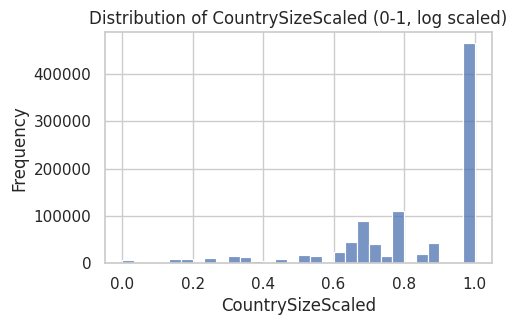

In [10]:
# 3. COUNTRY SIZE (SCALED 0–1)
# use total flights for each country in 2019,
# then scale 0-1 similarly.

if 'STATE_NAME' in df_featured.columns:
    # Group by country and sum 2019 flights
    df_2019_country = df_2019.groupby('STATE_NAME')['DailyFlights'].sum().reset_index()
    df_2019_country.rename(columns={'DailyFlights': 'CountryTotal2019'}, inplace=True)

    # Merge with main dataframe
    df_featured = pd.merge(df_featured, df_2019_country, on='STATE_NAME', how='left')

    # Apply log transform to handle wide range and zeros (log(x+1))
    df_featured['LogCountryTotal2019'] = df_featured['CountryTotal2019'].apply(
        lambda x: np.log(x + 1) if pd.notnull(x) else np.nan
    )

    # Compute min and max on the log-transformed values (ignoring missing values)
    log_country_min = df_featured['LogCountryTotal2019'].min(skipna=True)
    log_country_max = df_featured['LogCountryTotal2019'].max(skipna=True)

    # Scale the log-transformed values to [0,1]
    df_featured['CountrySizeScaled'] = df_featured['LogCountryTotal2019'].apply(
        lambda x: (x - log_country_min) / (log_country_max - log_country_min + 1e-9) if pd.notnull(x) else np.nan
    )
else:
    # If 'STATE_NAME' is not in the DataFrame, default to 0
    df_featured['CountrySizeScaled'] = 0

# Plot the distribution of the scaled country size
plt.figure(figsize=(5,3))
sns.histplot(df_featured['CountrySizeScaled'].dropna(), bins=30)
plt.title("Distribution of CountrySizeScaled (0-1, log scaled)")
plt.xlabel("CountrySizeScaled")
plt.ylabel("Frequency")
plt.show()


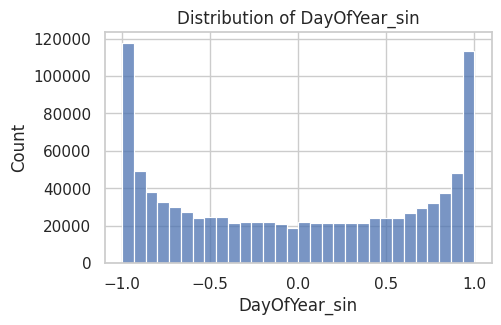

In [11]:
# 4. SEASONALITY AS A CYCLICAL DAY-OF-YEAR
# We can create sin/cos transforms for the day of year (1..365 or 366).
# day_of_year_sin = sin(2π * DayOfYear / 365)
# day_of_year_cos = cos(2π * DayOfYear / 365)

df_featured['DayOfYear'] = df_featured['FLT_DATE'].dt.dayofyear
df_featured['DayOfYear_sin'] = np.sin(2 * np.pi * df_featured['DayOfYear'] / 365)
df_featured['DayOfYear_cos'] = np.cos(2 * np.pi * df_featured['DayOfYear'] / 365)

plt.figure(figsize=(5,3))
sns.histplot(df_featured['DayOfYear_sin'], bins=30)
plt.title("Distribution of DayOfYear_sin")
plt.show()

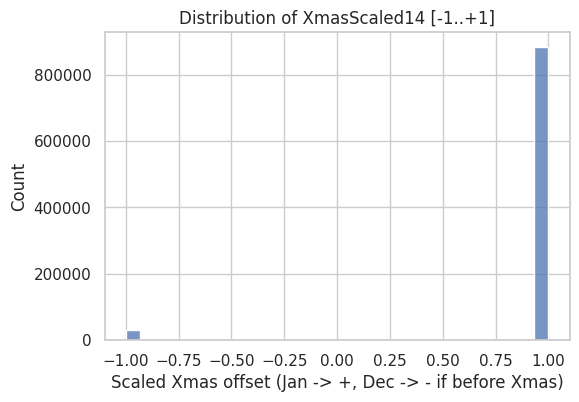

In [12]:
# 5. Christmas effect

# Assuming df_featured has 'Month' and 'Day' columns
df_featured['XmasScaled14'] = np.nan  # Initialize

# 1) If Month=12, offset = Day - 25
mask_dec = df_featured['MONTH_NUM'] == 12
df_featured.loc[mask_dec, 'XmasScaled14'] = df_featured.loc[mask_dec, 'Day'] - 25

# 2) If Month=1, offset = Day + 6
mask_jan = df_featured['MONTH_NUM'] == 1
df_featured.loc[mask_jan, 'XmasScaled14'] = df_featured.loc[mask_jan, 'Day'] + 6

# 3) Clamp any out-of-range or NaN values to 14, then scale
df_featured['XmasScaled14'] = df_featured['XmasScaled14'].fillna(14)          # If missing => set to 14
df_featured['XmasScaled14'] = df_featured['XmasScaled14'].clip(-14, 14)       # Constrain to [-14, +14]
df_featured['XmasScaled14'] = df_featured['XmasScaled14'] / 14.0              # Final scale to [-1..+1]


# Let's see distribution
plt.figure(figsize=(6,4))
sns.histplot(df_featured['XmasScaled14'], bins=29)  # -1..+1 => ~29 "bins" for integer steps if you like
plt.title("Distribution of XmasScaled14 [-1..+1]")
plt.xlabel("Scaled Xmas offset (Jan -> +, Dec -> - if before Xmas)")
plt.show()




In [13]:
# Drop the unwanted columns:
drop_cols = ['APT_NAME', 'MONTH_NUM', 'Day', 'DAY_OF_WEEK', 'DayOfWeek', 'DayOfYear', 'FLT_DEP_1', 'FLT_ARR_1', 'AvgFlights2019', 'LogAvgFlights2019','CountryTotal2019','LogCountryTotal2019']
df_featured.drop(columns=drop_cols, inplace=True, errors='ignore')

# Drop NaN values
before_drop = df_featured.shape[0]
df_featured.dropna(inplace=True)
after_drop = df_featured.shape[0]
dropped_count = before_drop - after_drop
percent_dropped = dropped_count / before_drop * 100

print(f"Dropped {dropped_count} rows out of {before_drop} total (~{percent_dropped:.2f}%).")

Dropped 366 rows out of 983842 total (~0.04%).


In [14]:
# show featured data
print(df_featured.info())
print(df_featured.describe())
print("Data shape:", df_cleaned.shape)
df_featured.head()


<class 'pandas.core.frame.DataFrame'>
Index: 983476 entries, 366 to 983841
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   YEAR               983476 non-null  int64         
 1   FLT_DATE           983476 non-null  datetime64[ns]
 2   APT_ICAO           983476 non-null  object        
 3   STATE_NAME         983476 non-null  object        
 4   DailyFlights       983476 non-null  int64         
 5   DayOfWeek_sin      983476 non-null  float64       
 6   DayOfWeek_cos      983476 non-null  float64       
 7   AirportSizeScaled  983476 non-null  float64       
 8   CountrySizeScaled  983476 non-null  float64       
 9   DayOfYear_sin      983476 non-null  float64       
 10  DayOfYear_cos      983476 non-null  float64       
 11  XmasScaled14       983476 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 97.5+ MB
None
                YEAR 

YEAR   FLT_DATE APT_ICAO STATE_NAME  DailyFlights  DayOfWeek_sin  \
366  2016 2016-01-01     EBAW    Belgium             7      -0.433884   
367  2016 2016-01-02     EBAW    Belgium            20      -0.974928   
368  2016 2016-01-03     EBAW    Belgium            27      -0.781831   
369  2016 2016-01-04     EBAW    Belgium            35       0.000000   
370  2016 2016-01-05     EBAW    Belgium            25       0.781831   

     DayOfWeek_cos  AirportSizeScaled  CountrySizeScaled  DayOfYear_sin  \
366      -0.900969           0.441857           0.640187       0.017213   
367      -0.222521           0.441857           0.640187       0.034422   
368       0.623490           0.441857           0.640187       0.051620   
369       1.000000           0.441857           0.640187       0.068802   
370       0.623490           0.441857           0.640187       0.085965   

     DayOfYear_cos  XmasScaled14  
366       0.999852      0.500000  
367       0.999407      0.571429  
368       0.998667      0.642857  
369       0.997630      0.714286  
370       0.996298      0.785714

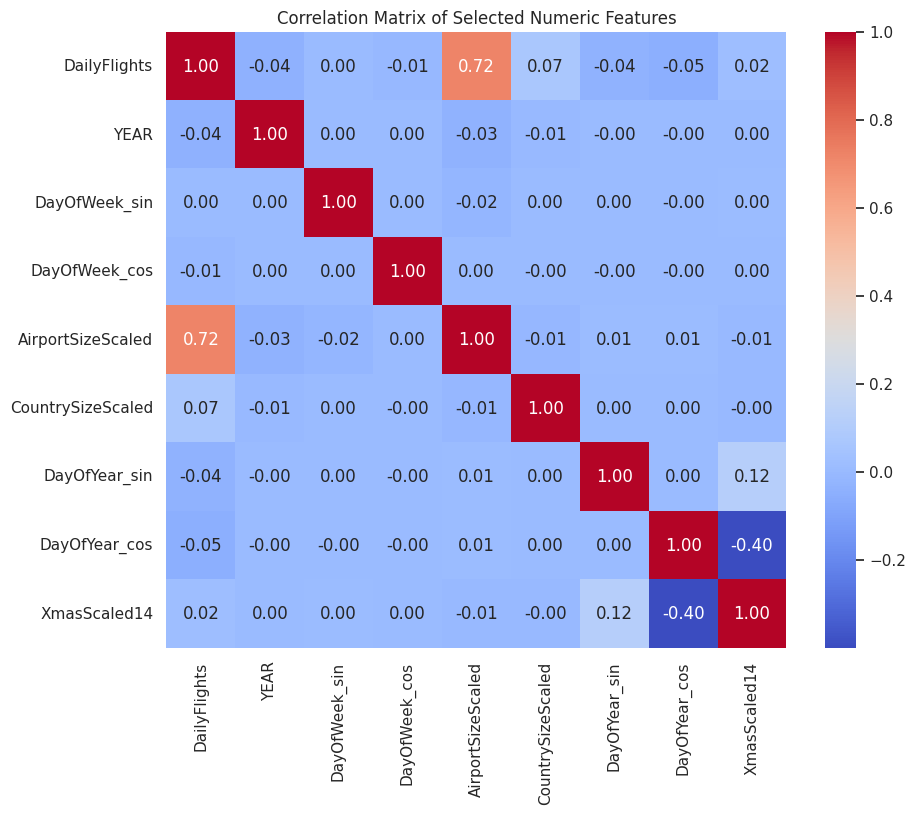

In [84]:
# correlation of features
# 1.1 Select only numeric columns for correlation
numeric_cols = [
    'DailyFlights',
    'YEAR',
    'DayOfWeek_sin',
    'DayOfWeek_cos',
    'AirportSizeScaled',
    'CountrySizeScaled',
    'DayOfYear_sin',
    'DayOfYear_cos',
    'XmasScaled14',
]

# 1.2 Compute correlation
corr_matrix = df_featured[numeric_cols].corr()

# 1.3 Plot as heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Numeric Features")
plt.show()

# 5. MODELING


In [28]:
# imports
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping


In [27]:
def evaluate_forecasts(y_true, y_pred, model_name="Model"):
    """
    Computes several metrics: RMSE, MAE, R^2.
    Prints them out and returns them as a dict.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R^2  = {r2:.3f}\n")
    return {"model": model_name, "RMSE": rmse, "MAE": mae, "R2": r2}

In [29]:
def plot_predictions(dates, y_true, y_pred, airport_code, model_name, label_desc=""):
    """
    Plots actual vs. predicted data for the given airport in 2024.
    label_desc can store info about 'featured' or 'all-airports'.
    """
    plt.figure(figsize=(10,4))
    plt.plot(dates, y_true, label="Actual")
    plt.plot(dates, y_pred, label=f"{model_name} Pred")
    plt.title(f"{airport_code} ({label_desc}): {model_name}\nActual vs. Predicted Daily Flights (2024)")
    plt.xlabel("Date")
    plt.ylabel("Flights")
    plt.legend()
    plt.show()

In [89]:
# 2.1. HOLT-WINTERS ------------------------------------------
def model_holt_winters(airport_code,
                       from_year=2016,
                       use_all_airports=False,
                       featured=False):
    """
    - train set:
        if use_all_airports=True => all airports in [from_year..2023],
        else => only airport_code in [from_year..2023].
    - test set: always airport_code in 2024.
    - column-dropping logic:
        if featured=True => drop ["FLT_DATE", "DailyFlights"]
        else => drop ["FLT_DEP_1","FLT_ARR_1","DailyFlights"]
    - But Holt-Winters uses univariate y only, ignoring X.
    """

    global df_cleaned, df_featured
    df = df_featured if featured else df_cleaned

    # 1) Build train set
    if use_all_airports:
        train_df = df[(df["YEAR"] >= from_year) & (df["YEAR"] <= 2023)].copy()
    else:
        train_df = df[(df["APT_ICAO"] == airport_code) &
                      (df["YEAR"] >= from_year) &
                      (df["YEAR"] <= 2023)].copy()

    # 2) Build test set => always that airport, year=2024
    test_df = df[(df["APT_ICAO"] == airport_code) & (df["YEAR"] == 2024)].copy()

    if train_df.empty or test_df.empty:
        print("[model_holt_winters] Not enough data for training or testing.")
        return None

    train_df.sort_values("FLT_DATE", inplace=True)
    test_df.sort_values("FLT_DATE", inplace=True)

    # Holt-Winters univariate => only y
    y_train = train_df["DailyFlights"].values
    y_test  = test_df["DailyFlights"].values

    # Fit ExponentialSmoothing with weekly seasonality=7
    hw_model = ExponentialSmoothing(
        y_train, trend="add", seasonal="add", seasonal_periods=7
    ).fit()

    # Forecast
    y_pred = hw_model.forecast(len(y_test))

    # Evaluate & Plot
    metrics_hw = evaluate_forecasts(y_test, y_pred, model_name="HoltWinters")
    label_desc = f"feat={featured}, allAir={use_all_airports}, from={from_year}"
    plot_predictions(test_df["FLT_DATE"].values, y_test, y_pred, airport_code, "HoltWinters", label_desc)

    return metrics_hw


In [94]:
# 5.2 RANDOM FOREST (with feature importance)
def model_random_forest(airport_code,
                        from_year=2016,
                        use_all_airports=False,
                        featured=False):
    """
    Train set:
        if use_all_airports=True => data from [from_year..2023]
        else => that airport in [from_year..2023]
    Test set => airport_code in 2024

    Drop columns depending on 'featured':
      if featured => drop ["FLT_DATE", "DailyFlights"]
      else         => drop ["FLT_DEP_1","FLT_ARR_1","DailyFlights"]

    Then remove leftover non-numeric columns.
    After fitting, prints top 10 feature importances.
    """

    global df_cleaned, df_featured
    df = df_featured if featured else df_cleaned

    # 1) Build train set
    if use_all_airports:
        train_df = df[(df["YEAR"] >= from_year) & (df["YEAR"] <= 2023)].copy()
    else:
        train_df = df[(df["APT_ICAO"] == airport_code) &
                      (df["YEAR"] >= from_year) &
                      (df["YEAR"] <= 2023)].copy()

    # 2) Build test set
    test_df = df[(df["APT_ICAO"] == airport_code) & (df["YEAR"] == 2024)].copy()

    if train_df.empty or test_df.empty:
        print("[model_random_forest] Not enough train/test data.")
        return None

    train_df.sort_values("FLT_DATE", inplace=True)
    test_df.sort_values("FLT_DATE", inplace=True)

    # Determine which columns to drop
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DEP_1", "FLT_ARR_1", "DailyFlights"]

    # y
    y_train = train_df["DailyFlights"].values
    y_test  = test_df["DailyFlights"].values

    # X: drop the designated columns
    X_train_df = train_df.drop(columns=drop_cols, errors="ignore")
    X_test_df  = test_df.drop(columns=drop_cols, errors="ignore")

    # Also drop any non-numeric columns
    non_numeric_train = X_train_df.select_dtypes(exclude=[np.number]).columns
    X_train_df.drop(columns=non_numeric_train, inplace=True)
    non_numeric_test  = X_test_df.select_dtypes(exclude=[np.number]).columns
    X_test_df.drop(columns=non_numeric_test, inplace=True)

    X_train = X_train_df.values
    X_test  = X_test_df.values

    # Train model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate & plot
    metrics_rf = evaluate_forecasts(y_test, y_pred, model_name="RandomForest")
    label_desc = f"feat={featured}, allAir={use_all_airports}, from={from_year}"
    plot_predictions(test_df["FLT_DATE"].values, y_test, y_pred, airport_code, "RandomForest", label_desc)

    # 3) FEATURE IMPORTANCE
    if X_train_df.shape[1] > 0:
        importances = rf.feature_importances_
        feat_names = X_train_df.columns
        # Combine into a small DataFrame for display
        imp_df = pd.DataFrame({
            'Feature': feat_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 RandomForest Features:")
        print(imp_df.head(10).to_string(index=False))
        print("...")
    else:
        print("No numeric features found for RandomForest importance check.")

    return metrics_rf

In [95]:
# 5.3 XGBOOST (with feature importance)
import xgboost as xgb

def model_xgboost(airport_code,
                  from_year=2016,
                  use_all_airports=False,
                  featured=False):
    """
    Similar logic to RandomForest, but with XGBoost.
    After fitting, prints top 10 features by gain importance.
    """

    global df_cleaned, df_featured
    df = df_featured if featured else df_cleaned

    # Build train/test sets
    if use_all_airports:
        train_df = df[(df["YEAR"] >= from_year) & (df["YEAR"] <= 2023)].copy()
    else:
        train_df = df[(df["APT_ICAO"] == airport_code) &
                      (df["YEAR"] >= from_year) &
                      (df["YEAR"] <= 2023)].copy()

    test_df = df[(df["APT_ICAO"] == airport_code) & (df["YEAR"] == 2024)].copy()

    if train_df.empty or test_df.empty:
        print("[model_xgboost] Not enough data for train/test.")
        return None

    train_df.sort_values("FLT_DATE", inplace=True)
    test_df.sort_values("FLT_DATE", inplace=True)

    # Drop columns
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DEP_1","FLT_ARR_1","DailyFlights"]

    y_train = train_df["DailyFlights"].values
    y_test  = test_df["DailyFlights"].values

    X_train_df = train_df.drop(columns=drop_cols, errors="ignore")
    X_test_df  = test_df.drop(columns=drop_cols, errors="ignore")

    # drop non-numeric
    non_num_train = X_train_df.select_dtypes(exclude=[np.number]).columns
    X_train_df.drop(columns=non_num_train, inplace=True)

    non_num_test = X_test_df.select_dtypes(exclude=[np.number]).columns
    X_test_df.drop(columns=non_num_test, inplace=True)

    X_train = X_train_df.values
    X_test  = X_test_df.values

    # Train XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    metrics_xgb = evaluate_forecasts(y_test, y_pred, model_name="XGBoost")
    label_desc = f"feat={featured}, allAir={use_all_airports}, from={from_year}"
    plot_predictions(test_df["FLT_DATE"].values, y_test, y_pred, airport_code, "XGBoost", label_desc)

    # 4) FEATURE IMPORTANCE
    if X_train_df.shape[1] > 0:
        booster = xgb_model.get_booster()
        # 'gain' measures average gain of splits by feature
        imp_dict = booster.get_score(importance_type='gain')
        if len(imp_dict) > 0:
            imp_items = list(imp_dict.items())  # [(feat_name, score), ...]
            imp_df = pd.DataFrame(imp_items, columns=['Feature','Gain']).sort_values('Gain', ascending=False)

            print("\nTop 10 XGBoost Features by Gain:")
            print(imp_df.head(10).to_string(index=False))
            print("...")
        else:
            print("No feature importance results from XGBoost. Possibly zero splits.")
    else:
        print("No numeric features found for XGBoost importance check.")

    return metrics_xgb


In [91]:
 # 5.4. RNN (LSTM or GRU) --------------------------------------
    # We'll do a simple approach: feed the same features as X (like for RF/XGB).
    # For time-series, a more advanced approach would create sequences/wide windows.
    # Here, let's show a minimal example. For best results, implement a proper sliding window approach.

def model_rnn(airport_code,
              from_year=2016,
              use_all_airports=False,
              featured=False,
              use_lstm=False):
    """
    Single-step RNN for demonstration. If you want sequence windows,
    you'd need to do rolling windows for X.
    """
    global df_cleaned, df_featured
    df = df_featured if featured else df_cleaned

    # Train set
    if use_all_airports:
        train_df = df[(df["YEAR"] >= from_year) & (df["YEAR"] <= 2023)].copy()
    else:
        train_df = df[(df["APT_ICAO"] == airport_code) &
                      (df["YEAR"] >= from_year) &
                      (df["YEAR"] <= 2023)].copy()

    # Test set => airport_code in 2024
    test_df = df[(df["APT_ICAO"] == airport_code) & (df["YEAR"] == 2024)].copy()

    if train_df.empty or test_df.empty:
        print("[model_rnn] Not enough data.")
        return None

    train_df.sort_values("FLT_DATE", inplace=True)
    test_df.sort_values("FLT_DATE", inplace=True)

    # Drop columns
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DEP_1","FLT_ARR_1","DailyFlights"]

    y_train = train_df["DailyFlights"].values
    y_test  = test_df["DailyFlights"].values

    X_train_df = train_df.drop(columns=drop_cols, errors="ignore")
    X_test_df  = test_df.drop(columns=drop_cols, errors="ignore")

    # drop non-numeric
    non_num_train = X_train_df.select_dtypes(exclude=[np.number]).columns
    X_train_df.drop(columns=non_num_train, inplace=True)

    non_num_test = X_test_df.select_dtypes(exclude=[np.number]).columns
    X_test_df.drop(columns=non_num_test, inplace=True)

    X_train = X_train_df.values
    X_test  = X_test_df.values

    if X_train.shape[1] == 0:
        print("[model_rnn] no numeric features to train on. Skipping.")
        return None

    # Reshape for RNN => (samples, timesteps=1, features)
    X_train_3d = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_3d  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential()
    if use_lstm:
        model.add(LSTM(32, input_shape=(1, X_train.shape[1]), activation='relu'))
        model_name = "RNN_LSTM"
    else:
        model.add(GRU(32, input_shape=(1, X_train.shape[1]), activation='relu'))
        model_name = "RNN_GRU"

    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train_3d, y_train,
              validation_split=0.2,
              epochs=20,
              batch_size=256,
              callbacks=[early_stop],
              verbose=1)

    y_pred = model.predict(X_test_3d).flatten()

    metrics_rnn = evaluate_forecasts(y_test, y_pred, model_name=model_name)
    label_desc = f"feat={featured}, allAir={use_all_airports}, from={from_year}"
    plot_predictions(test_df["FLT_DATE"].values, y_test, y_pred, airport_code, model_name, label_desc)

    return metrics_rnn

In [96]:
# try different combinations
def run_experiments(airport_code="EGLL"):
    # We'll keep a list of combos
    combos = [
        # (featured, use_all_airports, from_year) - can try pre-featured data as comparison
        (True,  False, 2016),
        (True,  True,  2016),
        (True,  False, 2022),
        (True,  True,  2022),
    ]

    all_results = {}

    for (featured_bool, all_airports, start_yr) in combos:
        # Create a label for the approach
        # e.g. "Cleaned, SingleAirport, from=2016" or "Featured, AllAirports, from=2022"
        feat_str = "Featured" if featured_bool else "Cleaned"
        air_str  = "AllAirports" if all_airports else "SingleAirport"
        label    = f"{feat_str}, {air_str}, from={start_yr}"

        print(f"\n=== RUNNING {label} for {airport_code} ===\n")

        # Holt-Winters
        hw_res = model_holt_winters(
            airport_code,
            from_year=start_yr,
            use_all_airports=all_airports,
            featured=featured_bool
        )

        # RF
        rf_res = model_random_forest(
            airport_code,
            from_year=start_yr,
            use_all_airports=all_airports,
            featured=featured_bool
        )

        # XGBoost
        xgb_res = model_xgboost(
            airport_code,
            from_year=start_yr,
            use_all_airports=all_airports,
            featured=featured_bool
        )

        # RNN (GRU)
        rnn_gru_res = model_rnn(
            airport_code,
            from_year=start_yr,
            use_all_airports=all_airports,
            featured=featured_bool,
            use_lstm=False
        )

        # RNN (LSTM)
        rnn_lstm_res = model_rnn(
            airport_code,
            from_year=start_yr,
            use_all_airports=all_airports,
            featured=featured_bool,
            use_lstm=True
        )

        # Store results
        all_results[label] = {
            "HoltWinters": hw_res,
            "RandomForest": rf_res,
            "XGBoost": xgb_res,
            "RNN_GRU": rnn_gru_res,
            "RNN_LSTM": rnn_lstm_res
        }

    return all_results



=== RUNNING Featured, SingleAirport, from=2016 for EGLL ===



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


HoltWinters Performance:
  RMSE = 462.84
  MAE  = 425.75
  R^2  = -51.884



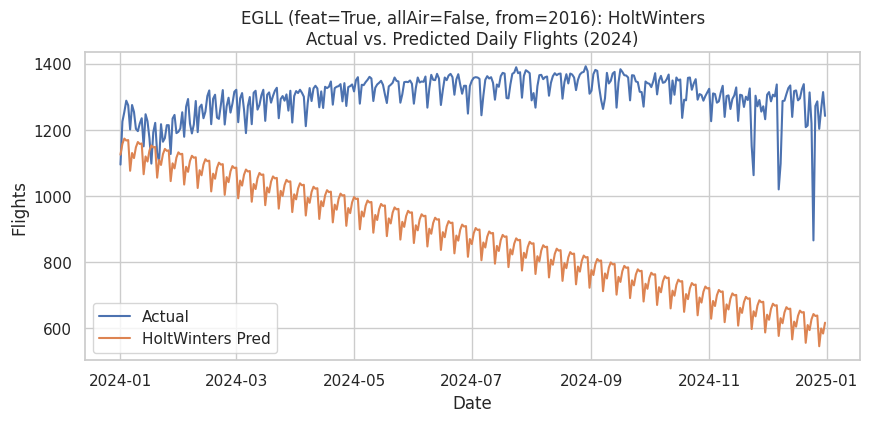

RandomForest Performance:
  RMSE = 70.69
  MAE  = 57.65
  R^2  = -0.234



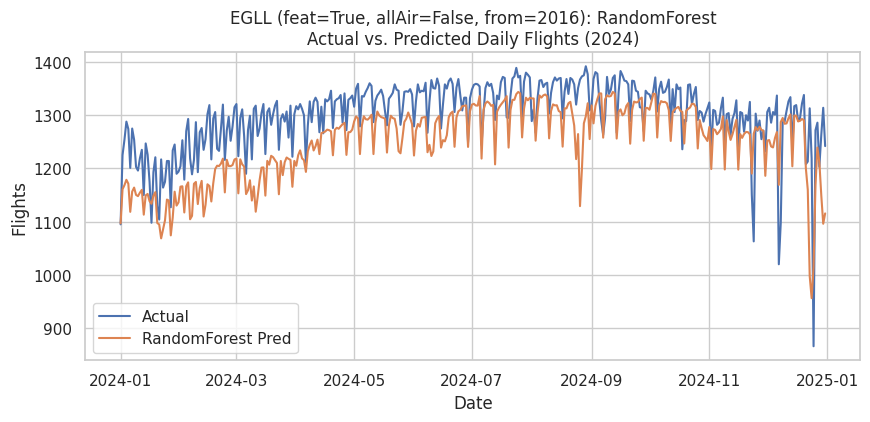


Top 10 RandomForest Features:
          Feature  Importance
             YEAR    0.798298
    DayOfYear_sin    0.125546
    DayOfYear_cos    0.062966
    DayOfWeek_sin    0.007273
     XmasScaled14    0.004734
    DayOfWeek_cos    0.001183
AirportSizeScaled    0.000000
CountrySizeScaled    0.000000
...
XGBoost Performance:
  RMSE = 71.95
  MAE  = 57.84
  R^2  = -0.278



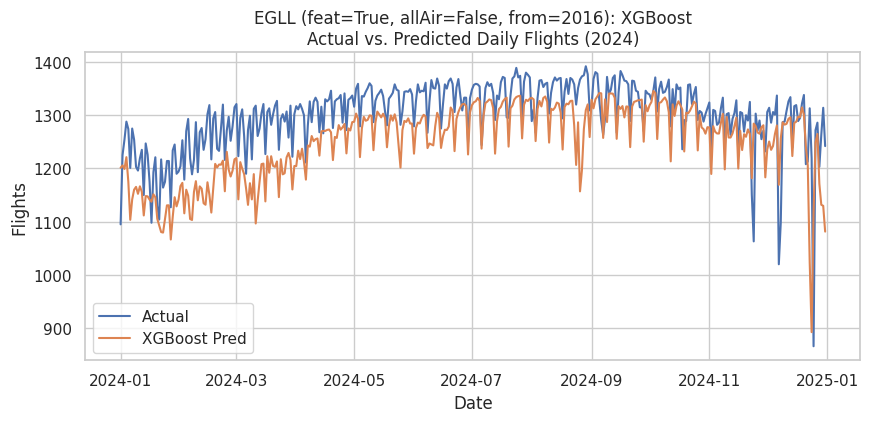


Top 10 XGBoost Features by Gain:
Feature          Gain
     f0 428837.031250
     f5  68589.273438
     f6  41509.816406
     f7  24747.755859
     f1   4586.519043
     f2   1589.888794
...
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 1503734.5000 - val_loss: 1689114.1250
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1442041.8750 - val_loss: 1620206.5000
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1370709.0000 - val_loss: 1556928.1250
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1316643.3750 - val_loss: 1498436.3750
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1260315.2500 - val_loss: 1443454.7500
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1224574.2500 - val_loss: 1390438.3750
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1176237.8750 - val_loss: 1338063.8750
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1119085.7500 - val_loss: 1285961.8750
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━

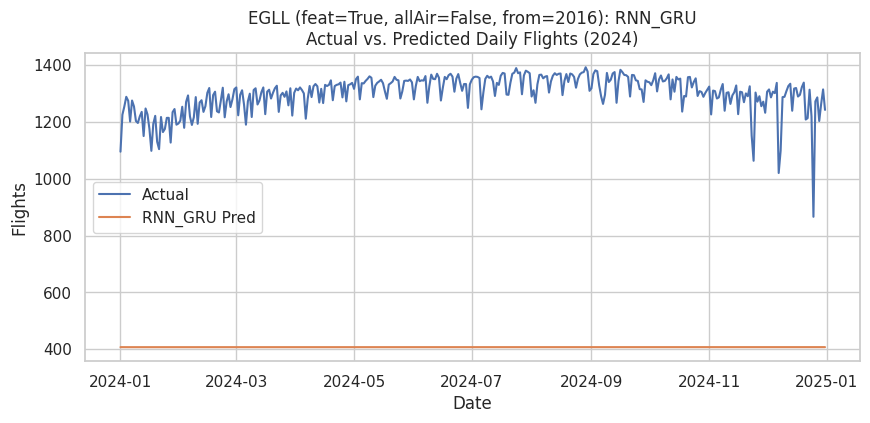

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1274194.7500 - val_loss: 1427504.8750
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1186389.0000 - val_loss: 1332059.0000
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1116483.6250 - val_loss: 1242802.3750
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1017952.5000 - val_loss: 1154267.6250
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 959543.2500 - val_loss: 1066306.1250
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 895953.6875 - val_loss: 979539.2500
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 818860.5625 - val_loss: 895077.5000
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 751265.9375 - val_loss: 812102.6875
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 676984.3125 - val_loss: 739238.8750
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 625858.8125 - val_loss: 668654.0625
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0

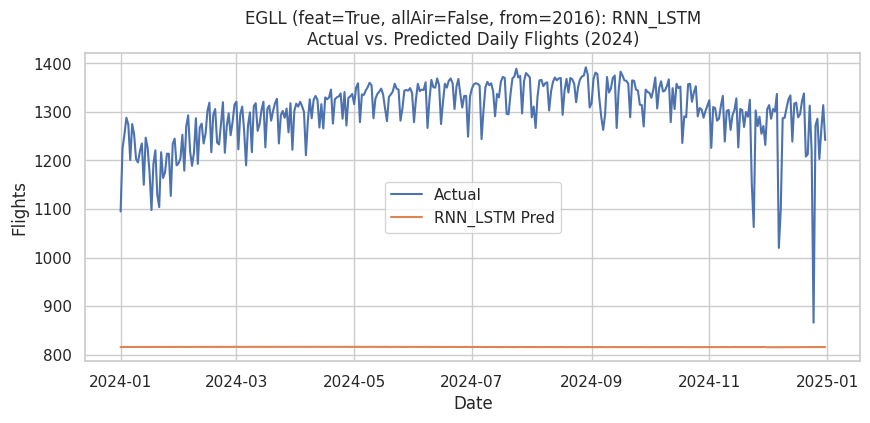


=== RUNNING Featured, AllAirports, from=2016 for EGLL ===



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


HoltWinters Performance:
  RMSE = 1179.43
  MAE  = 1177.58
  R^2  = -342.411



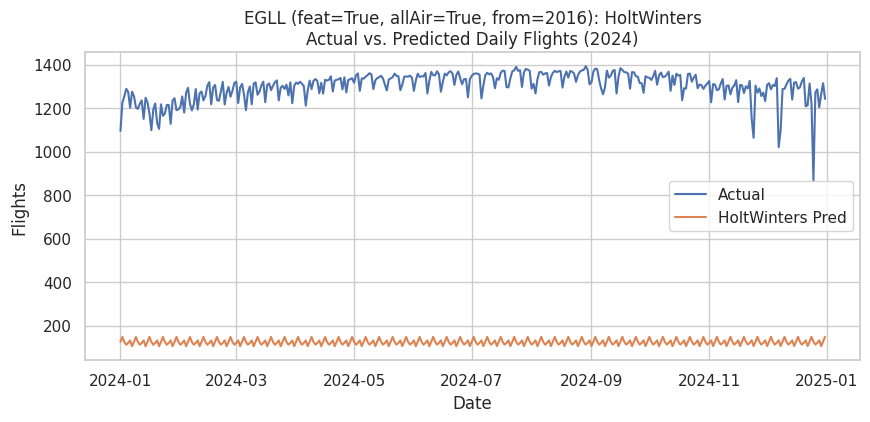

RandomForest Performance:
  RMSE = 72.29
  MAE  = 58.51
  R^2  = -0.290



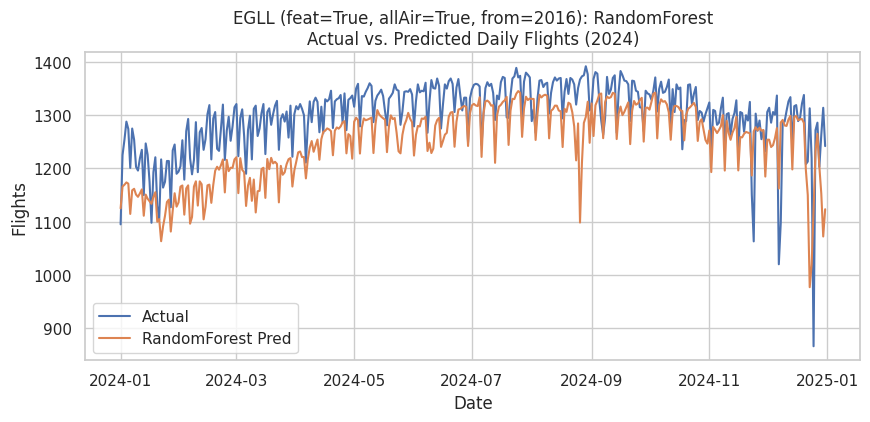


Top 10 RandomForest Features:
          Feature  Importance
AirportSizeScaled    0.842760
             YEAR    0.098691
    DayOfYear_cos    0.021552
    DayOfYear_sin    0.018642
CountrySizeScaled    0.011086
    DayOfWeek_sin    0.005425
     XmasScaled14    0.001044
    DayOfWeek_cos    0.000799
...
XGBoost Performance:
  RMSE = 74.48
  MAE  = 62.69
  R^2  = -0.369



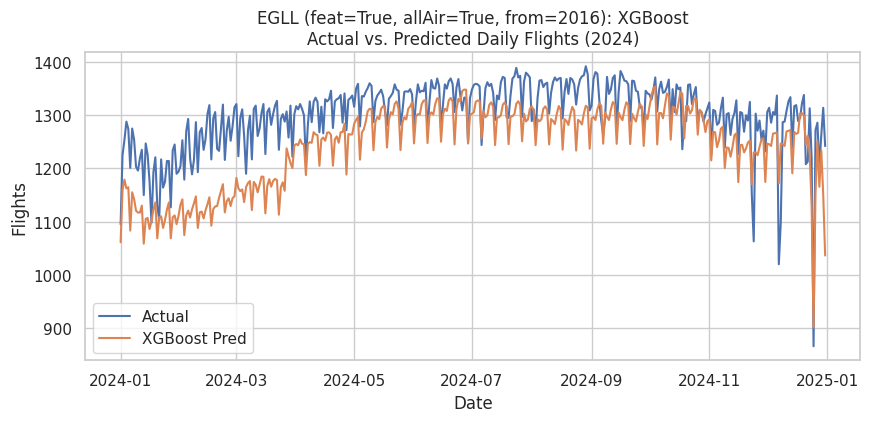


Top 10 XGBoost Features by Gain:
Feature         Gain
     f3 3.412846e+07
     f0 6.358354e+06
     f6 2.235425e+06
     f5 1.952067e+06
     f4 1.686288e+06
     f1 5.323063e+05
     f2 5.304109e+05
     f7 3.284866e+05
...
Epoch 1/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 52001.5508 - val_loss: 52085.9766
Epoch 2/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 48907.1367 - val_loss: 51639.2617
Epoch 3/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 48339.0859 - val_loss: 50331.9062
Epoch 4/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 47321.1914 - val_loss: 48418.6172
Epoch 5/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 44914.3477 - val_loss: 45713.2734
Epoch 6/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 42440.3281 - val_loss: 42395.3477
Epoch 7/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 39248.9766 - val_loss: 38495.5508
Epoch 8/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 36009.8281 - val_loss: 34419.66

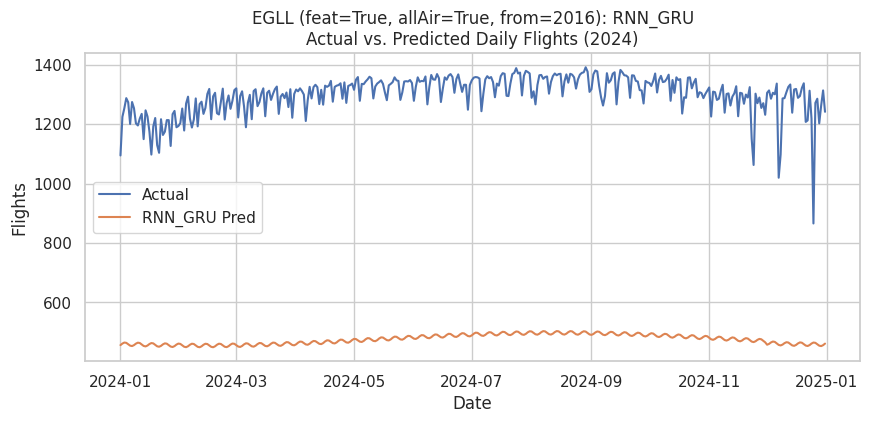

Epoch 1/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 48797.0977 - val_loss: 52260.0195
Epoch 2/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 49248.1289 - val_loss: 51784.4805
Epoch 3/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 48650.2969 - val_loss: 50613.5234
Epoch 4/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 47055.9766 - val_loss: 49035.1797
Epoch 5/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 45562.4492 - val_loss: 46524.6758
Epoch 6/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 43213.3398 - val_loss: 43180.6914
Epoch 7/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 39896.3516 - val_loss: 39322.9570
Epoch 8/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 36173.6797 - val_loss: 34778.5742
Epoch 9/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 32599.5781 - val_loss: 30771.2480
Epoch 10/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 30081.9258 - val_loss: 27489.5879
Epoch 11/20
2716/2716 ━━━━━━━

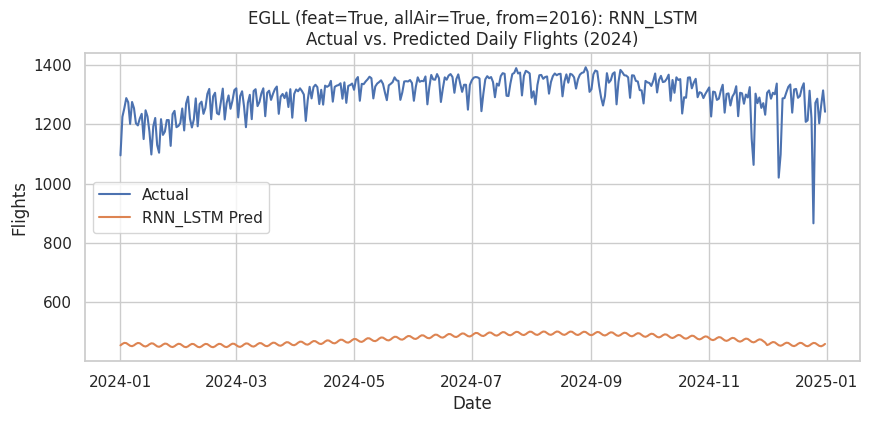


=== RUNNING Featured, SingleAirport, from=2022 for EGLL ===

HoltWinters Performance:
  RMSE = 719.13
  MAE  = 646.96
  R^2  = -126.667



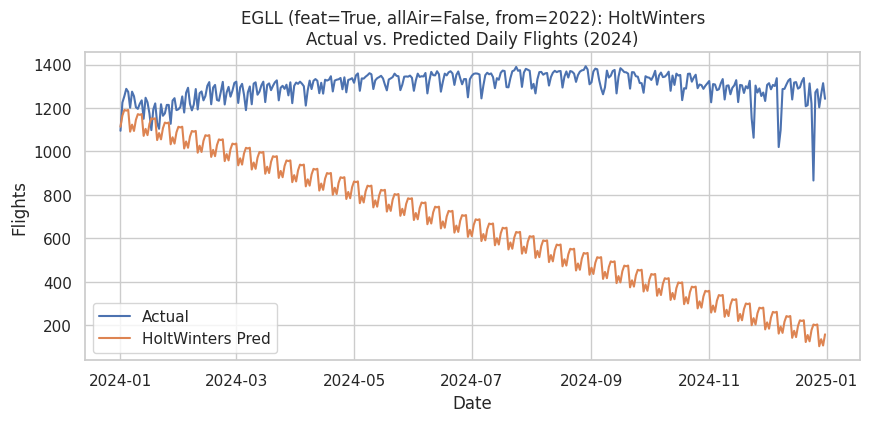

RandomForest Performance:
  RMSE = 71.40
  MAE  = 58.05
  R^2  = -0.258



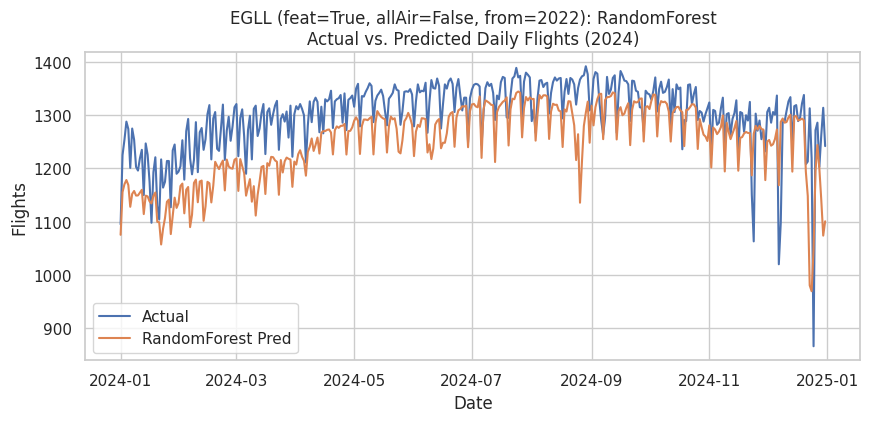


Top 10 RandomForest Features:
          Feature  Importance
             YEAR    0.412772
    DayOfYear_sin    0.307941
    DayOfYear_cos    0.242229
    DayOfWeek_sin    0.023896
     XmasScaled14    0.006672
    DayOfWeek_cos    0.006489
AirportSizeScaled    0.000000
CountrySizeScaled    0.000000
...
XGBoost Performance:
  RMSE = 75.25
  MAE  = 58.36
  R^2  = -0.398



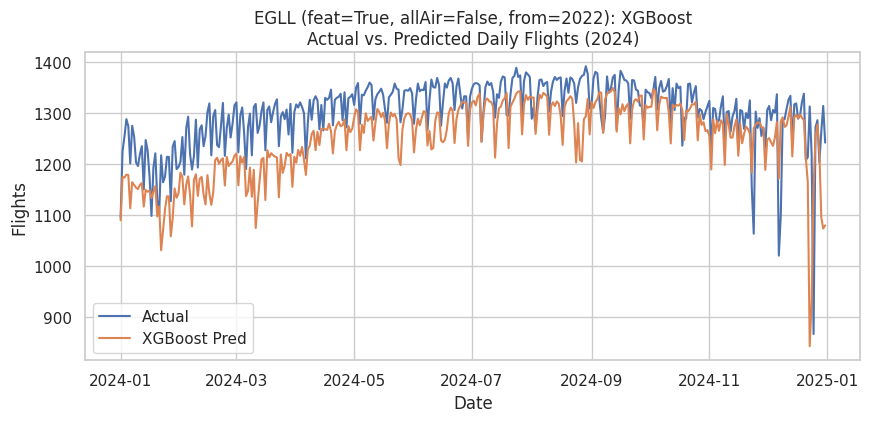


Top 10 XGBoost Features by Gain:
Feature         Gain
     f0 34317.359375
     f5 10960.463867
     f6  9128.904297
     f1  1042.885132
     f2   778.064453
     f7   752.876587
...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 738647.2500 - val_loss: 992574.0000
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 708306.7500 - val_loss: 959044.6250
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 686783.6250 - val_loss: 925855.2500
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 654695.8750 - val_loss: 893075.2500
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 627204.2500 - val_loss: 860686.4375
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 602836.0000 - val_loss: 828705.1875
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 576892.6250 - val_loss: 797198.2500
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 552501.0000 - val_loss: 766223.5000
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 522572.9062 -

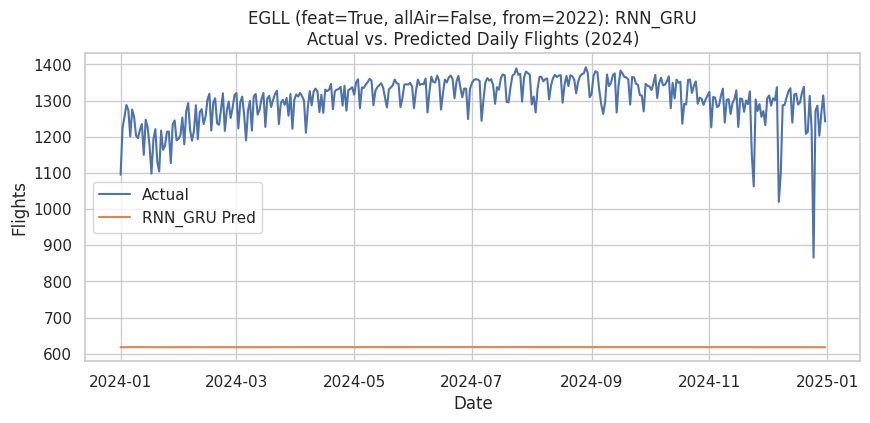

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 1490543.6250 - val_loss: 1858924.2500
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1452781.2500 - val_loss: 1816351.2500
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1416449.2500 - val_loss: 1774236.1250
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1388260.1250 - val_loss: 1732607.5000
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1343584.5000 - val_loss: 1691473.8750
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1299654.5000 - val_loss: 1650808.2500
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1270361.7500 - val_loss: 1610636.1250
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1239602.6250 - val_loss: 1571016.2500
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1204197.0000 - val_loss: 1531942.7500
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1173497.8750 - val_loss: 1493397.5000
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/ste

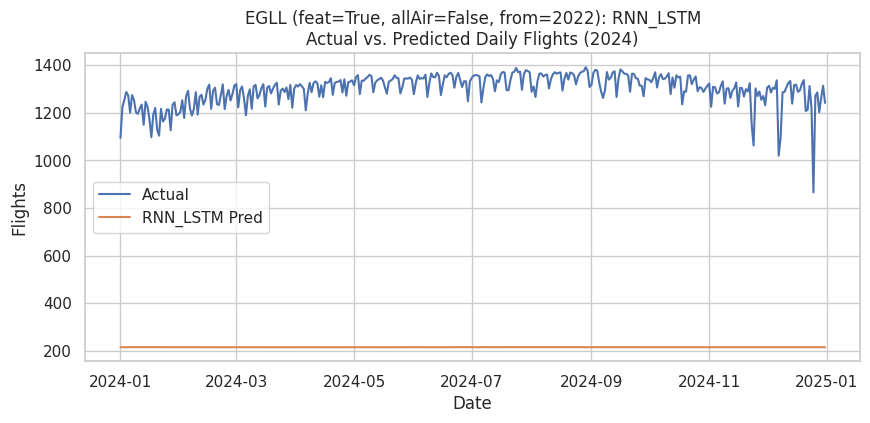


=== RUNNING Featured, AllAirports, from=2022 for EGLL ===



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


HoltWinters Performance:
  RMSE = 1192.68
  MAE  = 1190.73
  R^2  = -350.169



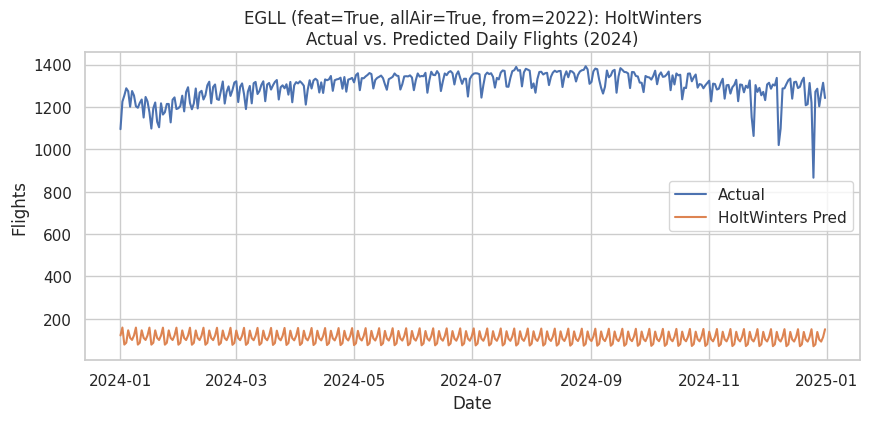

RandomForest Performance:
  RMSE = 72.00
  MAE  = 58.28
  R^2  = -0.280



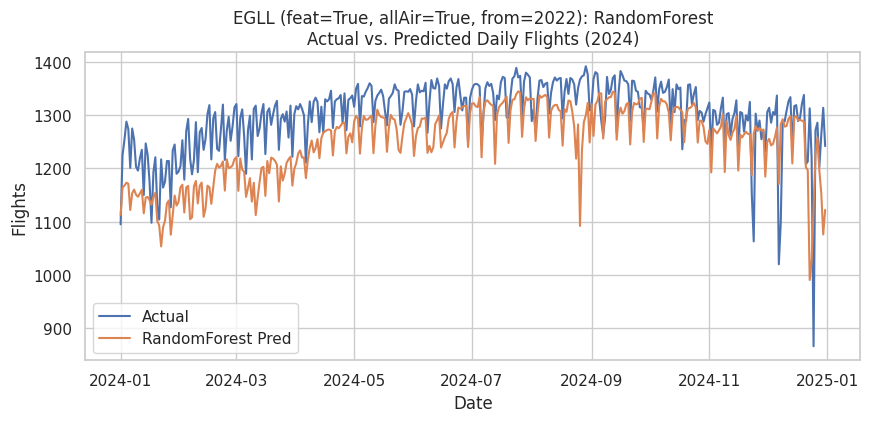


Top 10 RandomForest Features:
          Feature  Importance
AirportSizeScaled    0.937379
    DayOfYear_cos    0.020839
CountrySizeScaled    0.016974
    DayOfYear_sin    0.013873
             YEAR    0.005461
    DayOfWeek_sin    0.004392
    DayOfWeek_cos    0.000759
     XmasScaled14    0.000322
...
XGBoost Performance:
  RMSE = 72.39
  MAE  = 61.56
  R^2  = -0.294



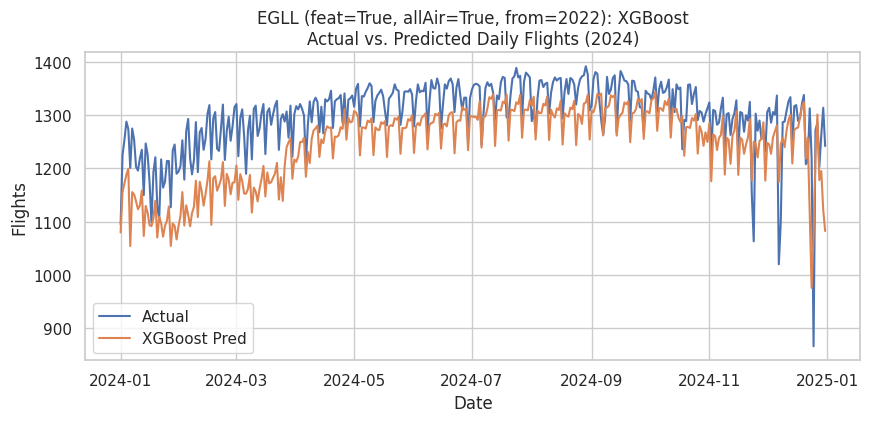


Top 10 XGBoost Features by Gain:
Feature         Gain
     f3 9.028200e+06
     f6 5.164397e+05
     f4 3.485496e+05
     f0 2.922548e+05
     f5 2.893648e+05
     f1 8.746477e+04
     f2 6.117657e+04
     f7 4.758421e+04
...
Epoch 1/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 73689.5000 - val_loss: 57024.2188
Epoch 2/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 46273.2031 - val_loss: 56773.2695
Epoch 3/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 46775.3750 - val_loss: 56912.8594
Epoch 4/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 46242.3125 - val_loss: 56600.2148
Epoch 5/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 46702.3320 - val_loss: 56431.8711
Epoch 6/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 45957.4102 - val_loss: 56347.7031
Epoch 7/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 45613.4883 - val_loss: 56275.2188
Epoch 8/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 46263.0312 - val_loss: 56049.3555
Epoch 9/20
714/714 ━━

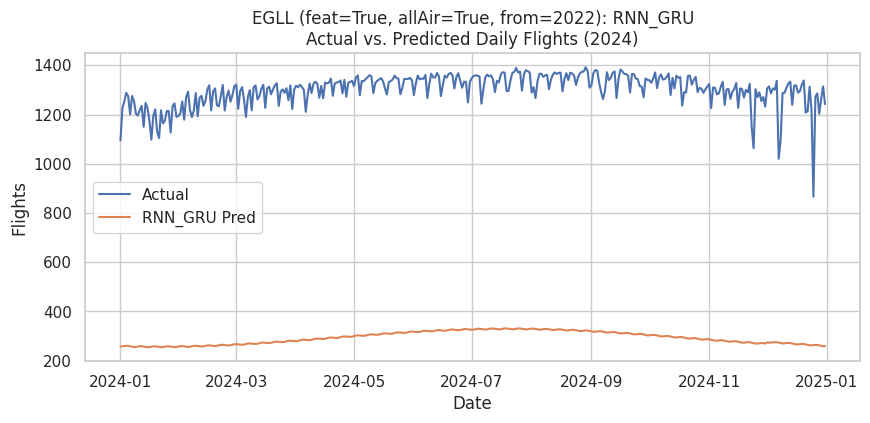

Epoch 1/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 57856.5820 - val_loss: 56937.5742
Epoch 2/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 46280.2891 - val_loss: 56897.7305
Epoch 3/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 46771.2500 - val_loss: 56686.1602
Epoch 4/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 45754.8516 - val_loss: 56777.9922
Epoch 5/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 46498.1797 - val_loss: 56688.3320
Epoch 6/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 46471.2344 - val_loss: 56501.7383
Epoch 7/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 46424.4062 - val_loss: 56925.9531
Epoch 8/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 45841.1367 - val_loss: 56185.5742
Epoch 9/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 46212.5547 - val_loss: 56257.1094
Epoch 10/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 45828.4570 - val_loss: 55773.5859
Epoch 11/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss

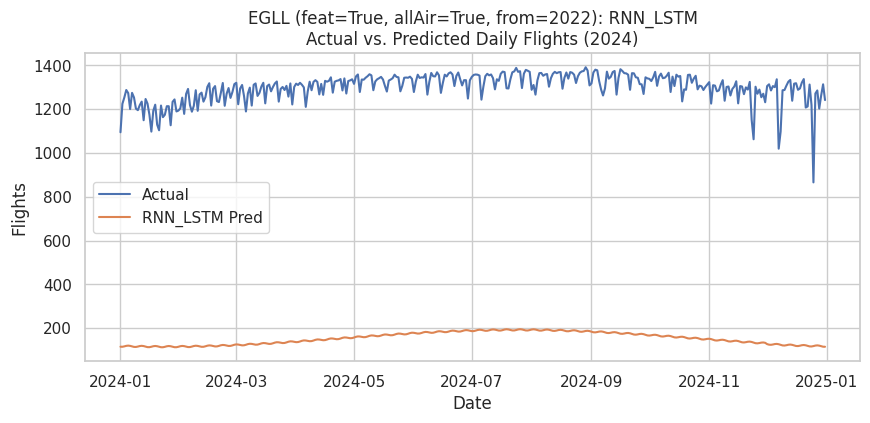

{'Featured, SingleAirport, from=2016': {'HoltWinters': {'model': 'HoltWinters',
   'RMSE': 462.8382957948638,
   'MAE': 425.7516396423383,
   'R2': -51.88418884501458},
  'RandomForest': {'model': 'RandomForest',
   'RMSE': 70.69235655964712,
   'MAE': 57.648306010928955,
   'R2': -0.2337074699758921},
  'XGBoost': {'model': 'XGBoost',
   'RMSE': 71.95190518781452,
   'MAE': 57.84001541137695,
   'R2': -0.2780618667602539},
  'RNN_GRU': {'model': 'RNN_GRU',
   'RMSE': 896.426028738568,
   'MAE': 894.1615600585938,
   'R2': -197.3792266845703},
  'RNN_LSTM': {'model': 'RNN_LSTM',
   'RMSE': 489.724667542896,
   'MAE': 485.5690002441406,
   'R2': -58.20675277709961}},
 'Featured, AllAirports, from=2016': {'HoltWinters': {'model': 'HoltWinters',
   'RMSE': 1179.4327684294406,
   'MAE': 1177.5812973363836,
   'R2': -342.4105674573858},
  'RandomForest': {'model': 'RandomForest',
   'RMSE': 72.28719734881446,
   'MAE': 58.51349726775957,
   'R2': -0.29000100842714316},
  'XGBoost': {'model'

In [97]:
run_experiments()

# Optimization

Fitted TBATS model summary:
Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  7. 365.]
Seasonal harmonics [3 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.826719
Trend (Beta): -0.123239
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-1.84970102e-07  5.23972719e-08  1.05822918e-07  1.06593078e-08]
AR coefficients []
MA coefficients []
Seed vector [1169.83840563    3.88123588    3.29532862    2.86935268   15.96132373
   -6.48313656  -21.36510605   -5.08211191   31.67485408  -54.86542088]

AIC 46401.547597

Double-Seasonal TBATS Performance (from=2016):
  RMSE = 198.53
  MAE  = 186.59
  R^2  = -8.731



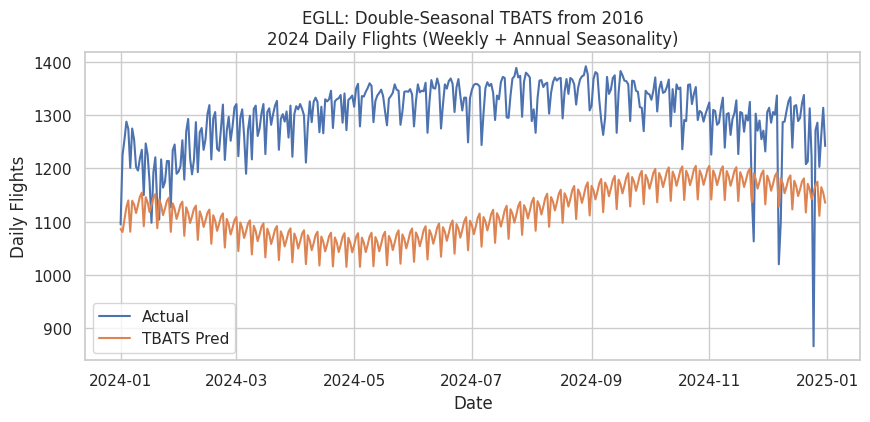

In [98]:
# 5.1 holt winters

!pip install tbats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tbats import TBATS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_egll_data_for_tbats(from_year=2016):
    """
    Returns daily train/test arrays suitable for TBATS double-seasonal modeling.
    We'll do:
      - train: [from_year..2023]
      - test: 2024
    """
    global df_featured
    df = df_featured.copy()

    # Filter for EGLL
    df_egll = df[df["APT_ICAO"]=="EGLL"].copy()

    # Sort by date
    df_egll.sort_values("FLT_DATE", inplace=True)

    # Train portion
    train_df = df_egll[(df_egll["YEAR"]>=from_year) & (df_egll["YEAR"]<=2023)]
    # Test portion
    test_df  = df_egll[df_egll["YEAR"]==2024]

    train_dates = train_df["FLT_DATE"].values
    test_dates  = test_df["FLT_DATE"].values

    y_train = train_df["DailyFlights"].values
    y_test  = test_df["DailyFlights"].values

    return y_train, y_test, train_dates, test_dates

def double_seasonal_tbats_egll(from_year=2016):
    y_train, y_test, train_dates, test_dates = get_egll_data_for_tbats(from_year)

    # TBATS can handle multiple seasonalities:
    estimator = TBATS(
        seasonal_periods=[7, 365],  # weekly + annual
        use_trend=True,            # you can set True/False depending on data
        use_arma_errors=False,     # can turn on ARMA errors if needed
        # Optionally tweak other parameters like use_box_cox, box_cox_bounds, etc.
    )

    # Fit the model on the training data
    model = estimator.fit(y_train)
    print("Fitted TBATS model summary:")
    print(model.summary())

    # Forecast for length of test set
    forecast_steps = len(y_test)
    y_pred = model.forecast(steps=forecast_steps)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    print(f"\nDouble-Seasonal TBATS Performance (from={from_year}):")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  R^2  = {r2:.3f}\n")

    # Quick plot of actual vs. forecast
    plt.figure(figsize=(10,4))
    plt.plot(test_dates, y_test, label="Actual")
    # The forecast is just an array of length steps, so we align it with test_dates
    plt.plot(test_dates, y_pred, label="TBATS Pred")
    plt.title(f"EGLL: Double-Seasonal TBATS from {from_year}\n2024 Daily Flights (Weekly + Annual Seasonality)")
    plt.xlabel("Date")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

    return model, (rmse, mae, r2)


model_tbats, metrics = double_seasonal_tbats_egll(from_year=2016)


Fitted TBATS model summary:
Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  7. 365.]
Seasonal harmonics [3 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.672445
Trend (Beta): -0.103455
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-1.49316054e-07  2.43908368e-07 -3.06413604e-08 -1.05737311e-07]
AR coefficients []
MA coefficients []
Seed vector [915.85373206  -6.71445442  -6.19552852 -13.59738841 -16.07576539
  -7.55607503   1.19685969   2.22495573 -12.07484362 -47.65938289]

AIC 10452.956990

Double-Seasonal TBATS Performance (from=2022):
  RMSE = 136.74
  MAE  = 129.15
  R^2  = -3.616



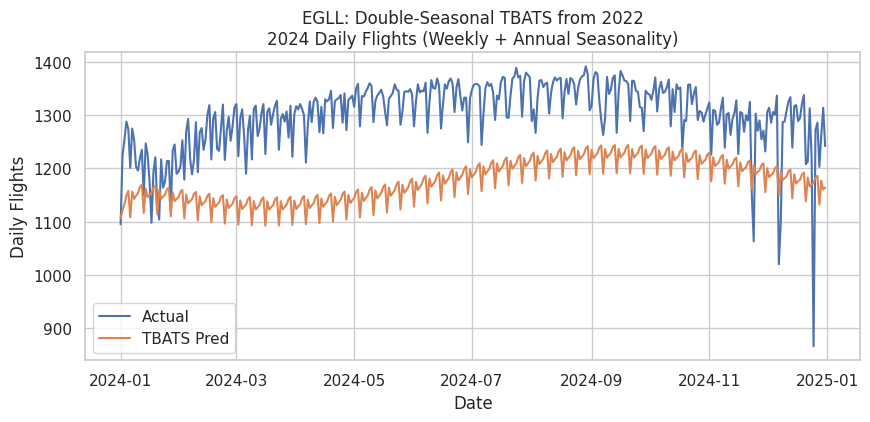

In [99]:
model_tbats, metrics = double_seasonal_tbats_egll(from_year=2022)

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def create_train_val_test_splits(df_cleaned_or_featured, airport_code="EGLL",
                                 from_year=2016, use_all_airports=False):
    """
    Splits data into:
      - train: from_year..2022
      - val: 2023
      - test: 2024
    for a chosen airport or all airports. Then you can do hyperparam search on train+val,
    and do a final check on test.
    """

    # If single airport or all
    if use_all_airports:
        data_1 = df_cleaned_or_featured[(df_cleaned_or_featured["YEAR"]>=from_year) &
                                        (df_cleaned_or_featured["YEAR"]<=2022)].copy()
        data_val = df_cleaned_or_featured[df_cleaned_or_featured["YEAR"]==2023].copy()
        data_test = df_cleaned_or_featured[df_cleaned_or_featured["YEAR"]==2024].copy()
    else:
        data_1 = df_cleaned_or_featured[(df_cleaned_or_featured["APT_ICAO"]==airport_code) &
                                        (df_cleaned_or_featured["YEAR"]>=from_year) &
                                        (df_cleaned_or_featured["YEAR"]<=2022)].copy()
        data_val = df_cleaned_or_featured[(df_cleaned_or_featured["APT_ICAO"]==airport_code) &
                                          (df_cleaned_or_featured["YEAR"]==2023)].copy()
        data_test = df_cleaned_or_featured[(df_cleaned_or_featured["APT_ICAO"]==airport_code) &
                                           (df_cleaned_or_featured["YEAR"]==2024)].copy()

    # Sort by date
    data_1.sort_values("FLT_DATE", inplace=True)
    data_val.sort_values("FLT_DATE", inplace=True)
    data_test.sort_values("FLT_DATE", inplace=True)

    # Combine train + val for the final fit, but keep them separate for param search
    return data_1, data_val, data_test

def prep_features_for_rf(df, featured=True):
    """
    If featured=True => we assume columns like FLT_DATE, DailyFlights must be dropped;
    else => adapt to your scenario.
    Then we remove any leftover non-numeric columns.
    Returns (X_df, y_series).
    """
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DATE", "FLT_DEP_1", "FLT_ARR_1", "DailyFlights"]

    df2 = df.drop(columns=drop_cols, errors="ignore").copy()
    # Drop non-numeric columns
    non_num = df2.select_dtypes(exclude=[np.number]).columns
    df2.drop(columns=non_num, inplace=True)

    y = df["DailyFlights"].values
    X_df = df2
    return X_df, y

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def tune_random_forest(df, airport_code="EGLL",
                       from_year=2016, use_all_airports=False,
                       featured=True):
    """
    1) Create train (2016..22) + val (2023), combine them for CV.
    2) Define param grid.
    3) Perform grid search for best Random Forest.
    """
    data_1, data_val, data_test = create_train_val_test_splits(
        df, airport_code, from_year, use_all_airports
    )
    # Combine train + val
    df_trainval = pd.concat([data_1, data_val], ignore_index=True)

    X_tv_df, y_tv = prep_features_for_rf(df_trainval, featured=featured)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5]
    }

    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(
        rf,
        param_grid=param_grid,
        scoring=make_scorer(rmse_scorer, greater_is_better=False),  # Negative RMSE scoring
        cv=3,  # You may consider TimeSeriesSplit(n_splits=3) if needed
        verbose=1
    )
    grid.fit(X_tv_df.values, y_tv)
    print("Best params:", grid.best_params_)
    print("Best score (neg RMSE):", grid.best_score_)

    # Refit final model on entire train+val data
    best_rf = grid.best_estimator_
    return best_rf, data_test

def final_evaluate_rf(best_rf, data_test, featured=True):
    """
    Evaluates the model on the test set using RMSE, MAE, and R².
    Additionally, prints and plots the feature importances.
    """
    X_test_df, y_test = prep_features_for_rf(data_test, featured=featured)
    y_pred = best_rf.predict(X_test_df.values)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = np.mean(np.abs(y_test - y_pred))
    r2   = r2_score(y_test, y_pred)
    print(f"Final Test RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.2f}")

    # Evaluate feature importance
    feature_names = X_test_df.columns
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("\nFeature Importances:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    # Plot feature importances
    plt.figure(figsize=(10,6))
    plt.title("Feature Importances")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

    return y_test, y_pred

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best score (neg RMSE): -335.79577228337655
Final Test RMSE=70.25, MAE=57.54, R^2=-0.22

Feature Importances:
YEAR: 0.7988
DayOfYear_sin: 0.1240
DayOfYear_cos: 0.0639
DayOfWeek_sin: 0.0074
XmasScaled14: 0.0047
DayOfWeek_cos: 0.0013
CountrySizeScaled: 0.0000
AirportSizeScaled: 0.0000


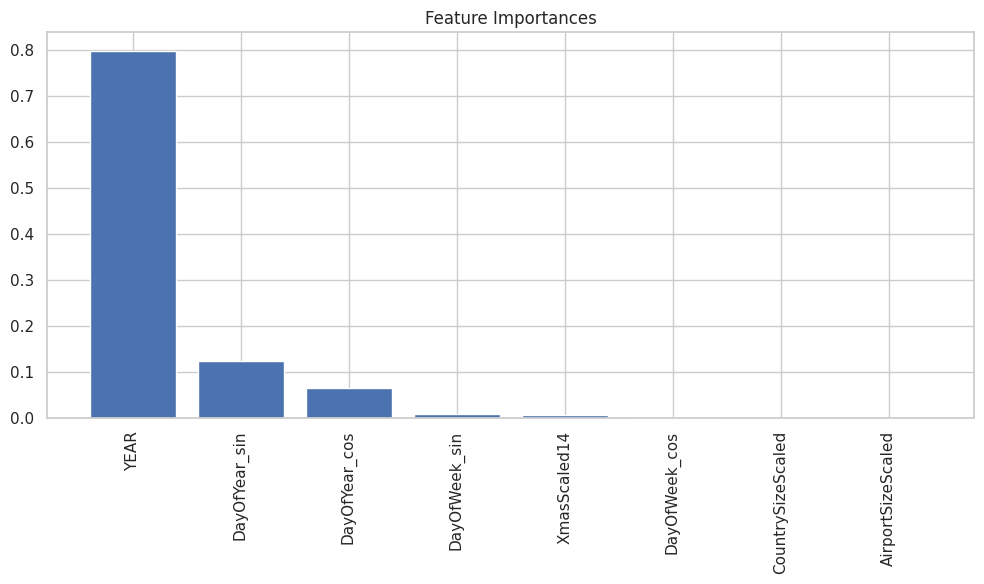

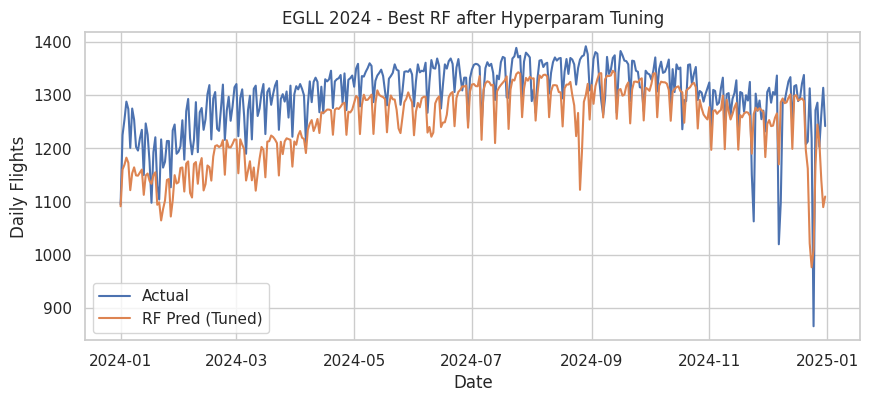

In [25]:
best_rf, test_data = tune_random_forest(df_featured, airport_code="EGLL",
                                        from_year=2016, use_all_airports=False,
                                        featured=True)

y_test, y_pred = final_evaluate_rf(best_rf, test_data, featured=True)

# Then plot predictions vs actual
dates_2024 = test_data["FLT_DATE"].values
plt.figure(figsize=(10,4))
plt.plot(dates_2024, y_test, label="Actual")
plt.plot(dates_2024, y_pred, label="RF Pred (Tuned)")
plt.title("EGLL 2024 - Best RF after Hyperparam Tuning")
plt.xlabel("Date")
plt.ylabel("Daily Flights")
plt.legend()
plt.show()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best score (neg RMSE): -335.79577228337655
Final Test RMSE=70.25, MAE=57.54, R^2=-0.22


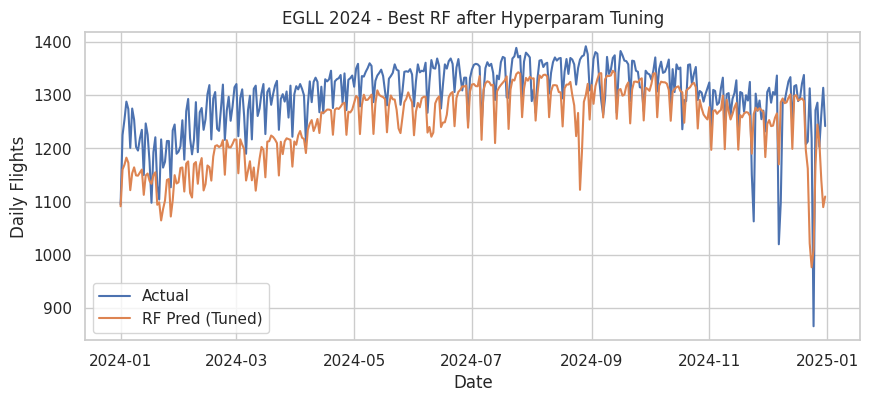

In [23]:
# try drop 2020 data
df_temp = df_featured.copy()
df_temp = df_temp[df_temp["YEAR"]!=2020]

best_rf, test_data = tune_random_forest(df_featured, airport_code="EGLL",
                                        from_year=2016, use_all_airports=False,
                                        featured=True)

y_test, y_pred = final_evaluate_rf(best_rf, test_data, featured=True)

# Then plot predictions vs actual
dates_2024 = test_data["FLT_DATE"].values
plt.figure(figsize=(10,4))
plt.plot(dates_2024, y_test, label="Actual")
plt.plot(dates_2024, y_pred, label="RF Pred (Tuned)")
plt.title("EGLL 2024 - Best RF after Hyperparam Tuning")
plt.xlabel("Date")
plt.ylabel("Daily Flights")
plt.legend()
plt.show()


--- XGBoost (from=2016, skip20_21=False, feat=True) ---
Train size: 2922  |  Test size: 366
RMSE=71.95, MAE=57.84, R^2=-0.278


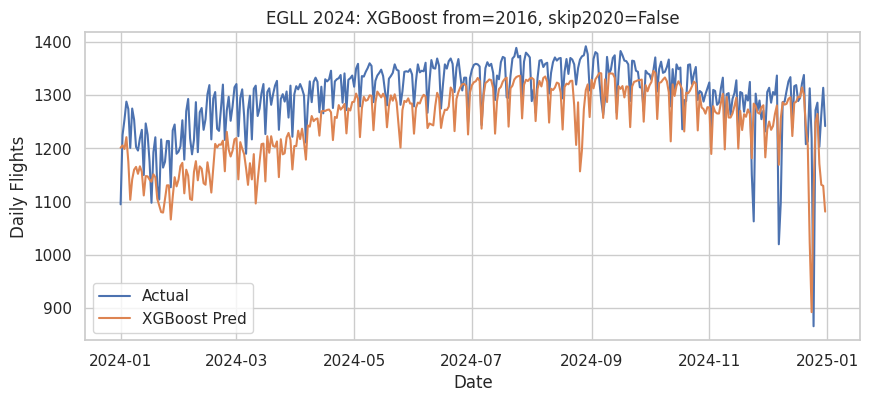


--- XGBoost (from=2016, skip20_21=True, feat=True) ---
Train size: 2556  |  Test size: 366
RMSE=71.06, MAE=57.47, R^2=-0.247


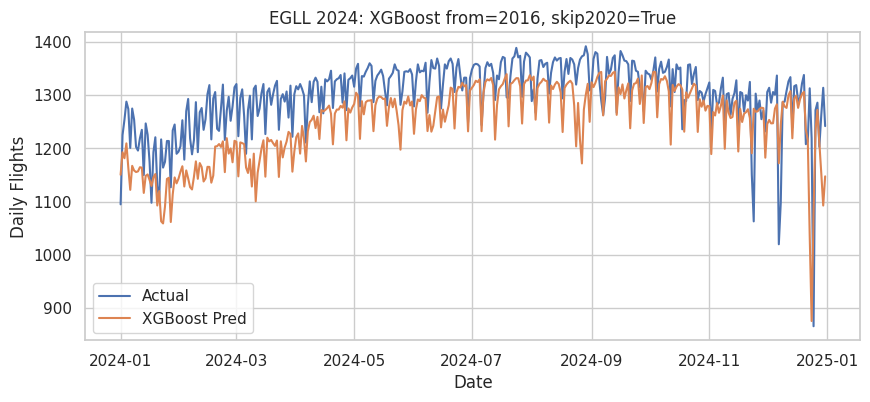

In [27]:
# xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_egll_data(df, from_year=2016, skip_20_21=False):
    """
    Returns:
      - train_df: from 'from_year'..2023 (optionally skipping 2021–2022)
      - test_df: 2024
    Single-airport approach: APT_ICAO == 'EGLL'.

    skip_20_21:
      if True, we exclude rows where YEAR in [2020, 2021].
      otherwise keep them.
    """

    # Filter for EGLL
    df_egll = df[df["APT_ICAO"]=="EGLL"].copy()
    df_egll.sort_values("FLT_DATE", inplace=True)

    # Build test set => year=2024
    test_df = df_egll[df_egll["YEAR"]==2024].copy()

    # Build train set => [from_year..2023] but maybe skip 2020–2021
    cond = (df_egll["YEAR"]>=from_year) & (df_egll["YEAR"]<=2023)
    if skip_20_21:
        cond = cond & (~df_egll["YEAR"].isin([2020]))

    train_df = df_egll[cond].copy()

    return train_df, test_df

def drop_and_get_xy(df, featured=True):
    """
    Drop columns not wanted in X, return (X, y) plus the DataFrame for quick reference.
    """
    if featured:
        drop_cols = ["FLT_DATE","DailyFlights"]
    else:
        # demonstration if you have a non-feature approach
        drop_cols = ["FLT_DATE","FLT_DEP_1","FLT_ARR_1","DailyFlights"]

    df2 = df.drop(columns=drop_cols, errors="ignore").copy()
    # remove non-numeric
    non_numeric = df2.select_dtypes(exclude=[np.number]).columns
    df2.drop(columns=non_numeric, inplace=True)

    X = df2.values
    y = df["DailyFlights"].values
    return X, y, df2

def run_xgboost_scenario(df, from_year=2016, skip_20_21=False, featured=True):
    """
    1) Prepare train/test sets for EGLL.
    2) Drop columns => get X_train, y_train, X_test, y_test
    3) Fit XGB, evaluate on 2024
    """
    train_df, test_df = prepare_egll_data(df, from_year=from_year, skip_20_21=skip_20_21)
    if train_df.empty or test_df.empty:
        print("No data for scenario. skipping.")
        return

    X_train, y_train, X_train_df = drop_and_get_xy(train_df, featured=featured)
    X_test, y_test, X_test_df   = drop_and_get_xy(test_df, featured=featured)

    # Fit XGB
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict test
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"\n--- XGBoost (from={from_year}, skip20_21={skip_20_21}, feat={featured}) ---")
    print(f"Train size: {X_train.shape[0]}  |  Test size: {X_test.shape[0]}")
    print(f"RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.3f}")

    # Quick plot
    dates_test = test_df["FLT_DATE"].values
    plt.figure(figsize=(10,4))
    plt.plot(dates_test, y_test, label="Actual")
    plt.plot(dates_test, y_pred, label="XGBoost Pred")
    desc = f"XGBoost from={from_year}, skip2020={skip_20_21}"
    plt.title(f"EGLL 2024: {desc}")
    plt.xlabel("Date")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

# Scenario A: keep all from 2016..2023
run_xgboost_scenario(df_featured, from_year=2016, skip_20_21=False, featured=True)

# Scenario B: from=2016 but SKIP 2020-2021
run_xgboost_scenario(df_featured, from_year=2016, skip_20_21=True, featured=True)


In [37]:
import numpy as np
import pandas as pd

def load_egll_data(df, airport_code="EGLL", from_year=2016):
    """
    Filters the data for a single airport (EGLL),
    from from_year up to 2024 inclusive.
    Sort by date, ensuring we have a continuous daily timeseries
    (or near continuous).
    Returns the filtered DataFrame.
    """
    df_egll = df[(df["APT_ICAO"]==airport_code) &
                 (df["YEAR"]>=from_year) &
                 (df["YEAR"]<=2024)].copy()
    df_egll.sort_values("FLT_DATE", inplace=True)
    return df_egll

def drop_and_keep_numeric(df, target_col="DailyFlights", drop_cols=None):
    """
    Splits out y=DailyFlights from the features.
    drop_cols: columns to remove from X, e.g. ["FLT_DATE","APT_ICAO", ...]
    Returns:
      X_df: numeric feature DataFrame
      y: target array
    """
    if drop_cols is None:
        drop_cols = []

    y = df[target_col].values
    X_df = df.drop(columns=drop_cols + [target_col], errors="ignore").copy()
    # Drop non-numeric
    non_num = X_df.select_dtypes(exclude=[np.number]).columns
    X_df.drop(columns=non_num, inplace=True)
    return X_df, y

def create_sliding_windows_bigarray(X, y, dates, window_size=14):
    """
    Creates sliding windows for the *entire series*,
    shape => (N_windowed, window_size, n_features)
    and one target per window => (N_windowed,).
    We also store the date for the 'target day' at index i.

    For i in [window_size..len(X)-1],
      X_seq[i-window_size..i-1], y[i], date[i].
    """
    X_seq = []
    y_seq = []
    date_seq = []

    N = len(y)
    for i in range(window_size, N):
        X_seq.append(X[i-window_size:i, :])
        y_seq.append(y[i])
        date_seq.append(dates[i])  # date of the 'target day' i

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    date_seq = np.array(date_seq)
    return X_seq, y_seq, date_seq


In [38]:
def split_train_test_on_date(date_seq, y_seq, X_seq, test_year=2024):
    """
    We have an array date_seq of shape (N_win,), which is the target day for each window.
    We'll separate the windows into train vs test based on date_seq's year.

    Returns X_train, y_train, X_test, y_test, date_test.
    """
    date_years = pd.to_datetime(date_seq).year
    train_mask = (date_years < test_year)
    test_mask  = (date_years == test_year)

    X_train = X_seq[train_mask]
    y_train = y_seq[train_mask]
    X_test  = X_seq[test_mask]
    y_test  = y_seq[test_mask]
    date_test = date_seq[test_mask]
    return X_train, y_train, X_test, y_test, date_test


In [39]:
# RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def build_rnn_model(input_shape, units=32, use_lstm=True):
    """
    If use_lstm=True => LSTM
    else => GRU
    """
    model = Sequential()
    if use_lstm:
        model.add(LSTM(units, activation='relu', input_shape=input_shape))
    else:
        model.add(GRU(units, activation='relu', input_shape=input_shape))

    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

def train_and_predict_rnn(df,
                          from_year=2016,
                          window_size=14,
                          use_lstm=True,
                          units=32,
                          epochs=20):
    """
    1) Build the entire big array of shape => (N_win, window_size, num_features)
    2) Split train vs test by date
    3) Train RNN, evaluate on test
    4) Plot the test predictions vs. actual
    """
    # 1) Load data
    df_egll = load_egll_data(df, "EGLL", from_year=from_year)
    # 2) Build X, y from dropping columns
    #    For example, drop "FLT_DATE", "APT_ICAO", etc., keep cyc features
    drop_cols = ["FLT_DATE","APT_ICAO","STATE_NAME","YEAR"]  # adjust as needed
    X_df, y = drop_and_keep_numeric(df_egll, target_col="DailyFlights", drop_cols=drop_cols)
    dates = df_egll["FLT_DATE"].values

    # 3) Convert X_df => array, create sliding windows for entire range
    X_np = X_df.values
    X_seq, y_seq, date_seq = create_sliding_windows_bigarray(X_np, y, dates, window_size=window_size)

    # 4) Train/test split by date
    X_train, y_train, X_test, y_test, date_test = split_train_test_on_date(date_seq, y_seq, X_seq, test_year=2024)
    print(f"Train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Test shape:  {X_test.shape}, y_test shape: {y_test.shape}")

    if X_train.size == 0 or X_test.size == 0:
        print("Not enough data for train or test.")
        return None

    # 5) Build RNN model
    model = build_rnn_model(input_shape=(window_size, X_train.shape[2]),
                            units=units, use_lstm=use_lstm)

    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    # 6) Predict on test set
    y_pred = model.predict(X_test).flatten()

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"Test RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.3f}")

    # 7) Plot
    plt.figure(figsize=(10,5))
    plt.plot(date_test, y_test, label="Actual")
    plt.plot(date_test, y_pred, label=f"RNN_{'LSTM' if use_lstm else 'GRU'} Pred")
    plt.title(f"EGLL 2024: RNN with sliding windows (win={window_size}), from={from_year}")
    plt.xlabel("Date")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

    return model, (rmse, mae, r2)


Train shape: (2915, 7, 7), y_train shape: (2915,)
Test shape:  (366, 7, 7), y_test shape: (366,)
Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1230592.5000 - val_loss: 1447159.3750
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1072493.6250 - val_loss: 110559.4609
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 191139.4688 - val_loss: 37415.1914
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 159984.2656 - val_loss: 27653.2051
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 158410.3594 - val_loss: 22378.1797
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 159748.0000 - val_loss: 23469.9648
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 155530.0469 - val_loss: 37456.3125
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Test RMSE=228.89, MAE=220.50, R^2=-11.934


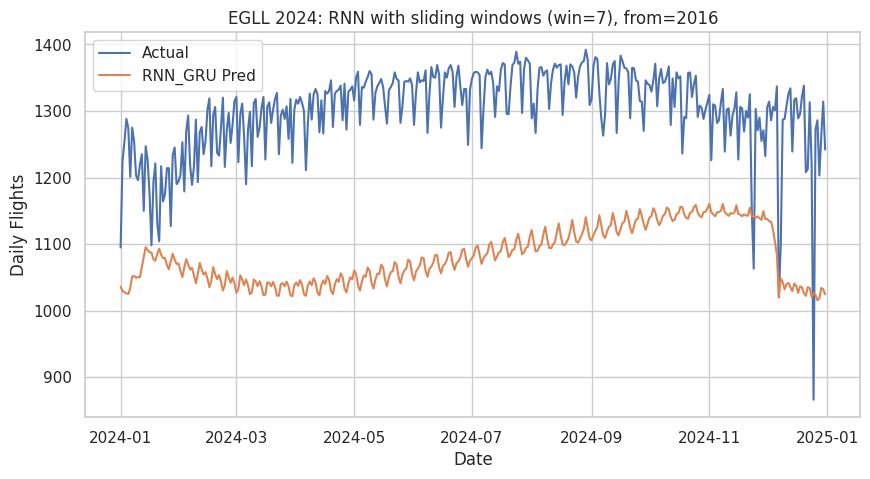

In [40]:
# Example usage:
model, metrics = train_and_predict_rnn(
    df_featured,
    from_year=2016,
    window_size=7,  # or 7,30, etc.
    use_lstm=False,   # or False for GRU
    units=64,        # hidden units
    epochs=30
)


In [ ]:
# try more possibiltiies with RNN - note: never finish

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

###############################
# 1. Data Splitting Functions #
###############################

def split_data_by_year(df, from_year=2016, skip_2020=False):
    """
    Splits the data into:
      - Train: from_year .. 2022 (optionally excluding rows from 2020)
      - Validation: 2023
      - Test: 2024
    Assumes the DataFrame has columns "YEAR" and "FLT_DATE".
    """
    df = df.copy()
    df.sort_values("FLT_DATE", inplace=True)
    train = df[(df["YEAR"] >= from_year) & (df["YEAR"] <= 2022)].copy()
    if skip_2020:
        train = train[train["YEAR"] != 2020].copy()
    val = df[df["YEAR"] == 2023].copy()
    test = df[df["YEAR"] == 2024].copy()
    return train, val, test

######################################
# 2. Sequence Creation for the RNN   #
######################################

def create_sequences(series, window_size):
    """
    Given a 1D numpy array 'series' and a window_size, creates sequences:
      - X: each sequence of length window_size
      - y: the value following each sequence
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

######################################
# 3. Build the RNN Model (LSTM)      #
######################################

def build_rnn_model(window_size, units=50, dropout_rate=0.0, learning_rate=0.001):
    """
    Builds and compiles an LSTM model for univariate time series forecasting.
    """
    model = Sequential()
    model.add(LSTM(units, input_shape=(window_size, 1)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

#####################################################
# 4. Train RNN with Early Stopping & Iterative Forecast
#####################################################

def train_rnn_model(df, from_year=2016, skip_2020=False, window_size=30,
                    epochs=50, batch_size=32, early_stopping_rounds=10):
    """
    Pipeline for RNN training and forecasting:
      1. Splits the data into train (2016-2022), validation (2023), test (2024).
         Optionally, excludes 2020 from training.
      2. Creates sliding-window sequences from the "DailyFlights" series.
      3. Builds and trains an LSTM model using early stopping on the validation set.
      4. Uses the last window (end of 2023) to iteratively forecast 2024.
      5. Evaluates the forecast versus the actual test values.
    """
    # --- Step 1: Split data by year ---
    train_df, val_df, test_df = split_data_by_year(df, from_year=from_year, skip_2020=skip_2020)

    # For RNN training, we use the univariate "DailyFlights" column.
    # Make sure the data is sorted by date.
    series_train = train_df.sort_values("FLT_DATE")["DailyFlights"].values
    series_val   = val_df.sort_values("FLT_DATE")["DailyFlights"].values
    series_test  = test_df.sort_values("FLT_DATE")["DailyFlights"].values  # for evaluation

    # --- Step 2: Create sequences ---
    X_train, y_train = create_sequences(series_train, window_size)
    X_val, y_val     = create_sequences(series_val, window_size)
    # Reshape to [samples, window_size, 1]
    X_train = X_train.reshape(-1, window_size, 1)
    X_val   = X_val.reshape(-1, window_size, 1)

    # --- Step 3: Build and train the model ---
    model = build_rnn_model(window_size, units=50, dropout_rate=0.2, learning_rate=0.001)
    es = EarlyStopping(monitor='val_loss', patience=early_stopping_rounds, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=1)

    # --- Step 4: Iterative Forecasting for 2024 ---
    # "Standing at the end of 2023": use the very last window from train+val as seed.
    # Combine train and validation to simulate available history at end of 2023.
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)
    series_train_val = train_val_df.sort_values("FLT_DATE")["DailyFlights"].values
    seed = series_train_val[-window_size:]  # last available window from end-2023

    forecast = []
    current_window = seed.copy()
    n_forecast = len(test_df)  # forecast horizon equals the number of test days in 2024
    for _ in range(n_forecast):
        # Prepare input for model (shape: (1, window_size, 1))
        input_seq = current_window.reshape(1, window_size, 1)
        # Predict next value
        pred = model.predict(input_seq)
        forecast.append(pred[0, 0])
        # Slide window: drop the first value and append the prediction
        current_window = np.append(current_window[1:], pred[0, 0])

    forecast = np.array(forecast)

    # --- Step 5: Evaluation ---
    # Align the forecast with the actual 2024 values (sorted by FLT_DATE)
    y_test = test_df.sort_values("FLT_DATE")["DailyFlights"].values
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mae  = mean_absolute_error(y_test, forecast)
    r2   = r2_score(y_test, forecast)
    print(f"Test Forecast Performance: RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.3f}")

    # Plot the forecast vs. actual values for 2024
    dates_test = test_df.sort_values("FLT_DATE")["FLT_DATE"].values
    plt.figure(figsize=(10, 4))
    plt.plot(dates_test, y_test, label="Actual")
    plt.plot(dates_test, forecast, label="Forecast")
    plt.title("RNN (LSTM) Forecast for 2024")
    plt.xlabel("Date")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

    return model, history, forecast

#########################################
# 5. Example Usage of the RNN Pipeline  #
#########################################

# Assuming 'df_featured' is your DataFrame with at least the columns:
# "FLT_DATE", "DailyFlights", and "YEAR" (with YEAR as int and FLT_DATE as date-like).
# Adjust 'from_year', 'skip_2020', etc. as needed.

model_rnn, history, forecast = train_rnn_model(
    df_featured,
    from_year=2016,
    skip_2020=False,         # Set to True to exclude 2020 data from training
    window_size=30,         # Use past 30 days to predict the next day
    epochs=50,              # Maximum number of epochs (early stopping will halt earlier if needed)
    batch_size=32,
    early_stopping_rounds=10
)


Ensembles

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def create_train_val_test_splits(df_cleaned_or_featured, airport_code="EGLL",
                                 from_year=2016, use_all_airports=False):
    """
    Splits data into:
      - train: from_year..2022
      - val: 2023
      - test: 2024
    for a chosen airport or all airports. Then you can do hyperparam search on train+val,
    and do a final check on test.
    """

    # If single airport or all
    if use_all_airports:
        data_1 = df_cleaned_or_featured[(df_cleaned_or_featured["YEAR"]>=from_year) &
                                        (df_cleaned_or_featured["YEAR"]<=2022)].copy()
        data_val = df_cleaned_or_featured[df_cleaned_or_featured["YEAR"]==2023].copy()
        data_test = df_cleaned_or_featured[df_cleaned_or_featured["YEAR"]==2024].copy()
    else:
        data_1 = df_cleaned_or_featured[(df_cleaned_or_featured["APT_ICAO"]==airport_code) &
                                        (df_cleaned_or_featured["YEAR"]>=from_year) &
                                        (df_cleaned_or_featured["YEAR"]<=2022)].copy()
        data_val = df_cleaned_or_featured[(df_cleaned_or_featured["APT_ICAO"]==airport_code) &
                                          (df_cleaned_or_featured["YEAR"]==2023)].copy()
        data_test = df_cleaned_or_featured[(df_cleaned_or_featured["APT_ICAO"]==airport_code) &
                                           (df_cleaned_or_featured["YEAR"]==2024)].copy()

    # Sort by date
    data_1.sort_values("FLT_DATE", inplace=True)
    data_val.sort_values("FLT_DATE", inplace=True)
    data_test.sort_values("FLT_DATE", inplace=True)

    # Combine train + val for the final fit, but keep them separate for param search
    return data_1, data_val, data_test

def prep_features_for_rf(df, featured=True):
    """
    If featured=True => we assume columns like FLT_DATE, DailyFlights must be dropped;
    else => adapt to your scenario.
    Then we remove any leftover non-numeric columns.
    Returns (X_df, y_series).
    """
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DATE", "FLT_DEP_1", "FLT_ARR_1", "DailyFlights"]

    df2 = df.drop(columns=drop_cols, errors="ignore").copy()
    # Drop non-numeric columns
    non_num = df2.select_dtypes(exclude=[np.number]).columns
    df2.drop(columns=non_num, inplace=True)

    y = df["DailyFlights"].values
    X_df = df2
    return X_df, y

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def tune_random_forest(df, airport_code="EGLL",
                       from_year=2016, use_all_airports=False,
                       featured=True):
    """
    1) Create train (2016..22) + val (2023), combine them for CV.
    2) Define param grid.
    3) Perform grid search for best Random Forest.
    """
    data_1, data_val, data_test = create_train_val_test_splits(
        df, airport_code, from_year, use_all_airports
    )
    # Combine train + val
    df_trainval = pd.concat([data_1, data_val], ignore_index=True)

    X_tv_df, y_tv = prep_features_for_rf(df_trainval, featured=featured)

    param_grid = {
        'n_estimators': [50],
        'max_depth': [None],
        'min_samples_leaf': [1] #just use previous results to save runtime
    }

    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(
        rf,
        param_grid=param_grid,
        scoring=make_scorer(rmse_scorer, greater_is_better=False),  # Negative RMSE scoring
        cv=3,  # You may consider TimeSeriesSplit(n_splits=3) if needed
        verbose=1
    )
    grid.fit(X_tv_df.values, y_tv)
    print("Best params:", grid.best_params_)
    print("Best score (neg RMSE):", grid.best_score_)

    # Refit final model on entire train+val data
    best_rf = grid.best_estimator_
    return best_rf, data_test

def final_evaluate_rf(best_rf, data_test, featured=True):
    """
    Evaluates the model on the test set using RMSE, MAE, and R².
    Additionally, prints and plots the feature importances.
    """
    X_test_df, y_test = prep_features_for_rf(data_test, featured=featured)
    y_pred = best_rf.predict(X_test_df.values)

    return y_test, y_pred



In [16]:
import xgboost as xgb

def model_xgboost(airport_code,
                  from_year=2016,
                  use_all_airports=False,
                  featured=False):
    """
    Similar logic to RandomForest, but with XGBoost.
    After fitting, prints top 10 features by gain importance.
    """

    global df_cleaned, df_featured
    df = df_featured if featured else df_cleaned

    # Build train/test sets
    if use_all_airports:
        train_df = df[(df["YEAR"] >= from_year) & (df["YEAR"] <= 2023)].copy()
    else:
        train_df = df[(df["APT_ICAO"] == airport_code) &
                      (df["YEAR"] >= from_year) &
                      (df["YEAR"] <= 2023)].copy()

    test_df = df[(df["APT_ICAO"] == airport_code) & (df["YEAR"] == 2024)].copy()

    if train_df.empty or test_df.empty:
        print("[model_xgboost] Not enough data for train/test.")
        return None

    train_df.sort_values("FLT_DATE", inplace=True)
    test_df.sort_values("FLT_DATE", inplace=True)

    # Drop columns
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DEP_1","FLT_ARR_1","DailyFlights"]

    y_train = train_df["DailyFlights"].values
    y_test  = test_df["DailyFlights"].values

    X_train_df = train_df.drop(columns=drop_cols, errors="ignore")
    X_test_df  = test_df.drop(columns=drop_cols, errors="ignore")

    # drop non-numeric
    non_num_train = X_train_df.select_dtypes(exclude=[np.number]).columns
    X_train_df.drop(columns=non_num_train, inplace=True)

    non_num_test = X_test_df.select_dtypes(exclude=[np.number]).columns
    X_test_df.drop(columns=non_num_test, inplace=True)

    X_train = X_train_df.values
    X_test  = X_test_df.values

    # Train XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    metrics_xgb = evaluate_forecasts(y_test, y_pred, model_name="XGBoost")

    return y_test, y_pred, metrics_xgb

In [17]:
def predict_rf_egll_2016(df_cleaned, df_featured):
    """
    RANDOM FOREST
    - Single airport (EGLL)
    - from=2016
    - featured=True
    Returns y_test, y_pred_rf
    """

    best_rf, test_data = tune_random_forest(df_featured, airport_code="EGLL",
                                        from_year=2016, use_all_airports=False,
                                        featured=True)

    y_test, y_pred = final_evaluate_rf(best_rf, test_data, featured=True)

    return y_test, y_pred



def predict_xgb_allair_2022(df_cleaned, df_featured):
    """
    XGBOOST
    - All airports
    - from=2022
    - featured=True
    Returns y_test, y_pred_xgb
    """
    y_test, y_pred, metrics_xgb = model_xgboost("EGLL", from_year=2022,
                                use_all_airports=True, featured=True)

    return y_test, y_pred



In [25]:
# 1. simple ensemble
"""
Combines them via:
simple average:
ens= (rf+xgb)/2
​
weighted average:
ens=𝛼⋅rf+(1−𝛼)⋅xgb
"""

def ensemble_rf_xgb(df_cleaned, df_featured, alpha=0.5):
    """
    1) Get predictions from RandomForest( single-airport from=2016 )
       and XGBoost( all-airports from=2022 ).
    2) Create ensemble:
       - simple average if alpha=0.5
       - or weighted average if alpha != 0.5
    3) Evaluate final on y_test
    4) Plot Actual vs. Ensemble
    """
    # 1) Get base model predictions
    y_test_rf, y_pred_rf = predict_rf_egll_2016(df_cleaned, df_featured)
    y_test_xgb, y_pred_xgb = predict_xgb_allair_2022(df_cleaned, df_featured)

    # 2) Make sure y_test arrays align, or just assume same shape
    #    If you want to verify, check that they are same length & same order of dates
    if len(y_test_rf) != len(y_test_xgb):
        print("Warning: mismatch in test set size.")
        # In practice, you might align them by date if needed
    y_test = y_test_rf  # or whichever is correct if they're identical

    # 3) Weighted ensemble
    y_pred_ens = alpha * y_pred_rf + (1.0 - alpha) * y_pred_xgb

    # Evaluate
    rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ens))
    mae_ens  = mean_absolute_error(y_test, y_pred_ens)
    r2_ens   = r2_score(y_test, y_pred_ens)

    print(f"Ensemble Weighted alpha={alpha} => RMSE={rmse_ens:.2f}, MAE={mae_ens:.2f}, R^2={r2_ens:.3f}")

    # 4) Plot
    # You likely have some date array for the test set in your model output. We'll pretend we store them:
    df_temp = df_featured[df_featured["APT_ICAO"]=="EGLL"].copy()
    df_temp = df_temp[df_temp["FLT_DATE"].dt.year == 2024]
    date_test = df_temp["FLT_DATE"].values

    plt.figure(figsize=(10,5))
    plt.plot(date_test, y_test, label="Actual")
    plt.plot(date_test, y_pred_rf, label="RF Pred")
    plt.plot(date_test, y_pred_xgb, label="XGB Pred")
    plt.plot(date_test, y_pred_ens, label="Ensemble")
    plt.title(f"RF+XGB Ensemble (alpha={alpha})")
    plt.xlabel("Date (2024)")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

    return y_pred_ens


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best score (neg RMSE): -335.79577228337655
XGBoost Performance:
  RMSE = 72.39
  MAE  = 61.56
  R^2  = -0.294

Ensemble Weighted alpha=0.5 => RMSE=70.14, MAE=59.21, R^2=-0.215


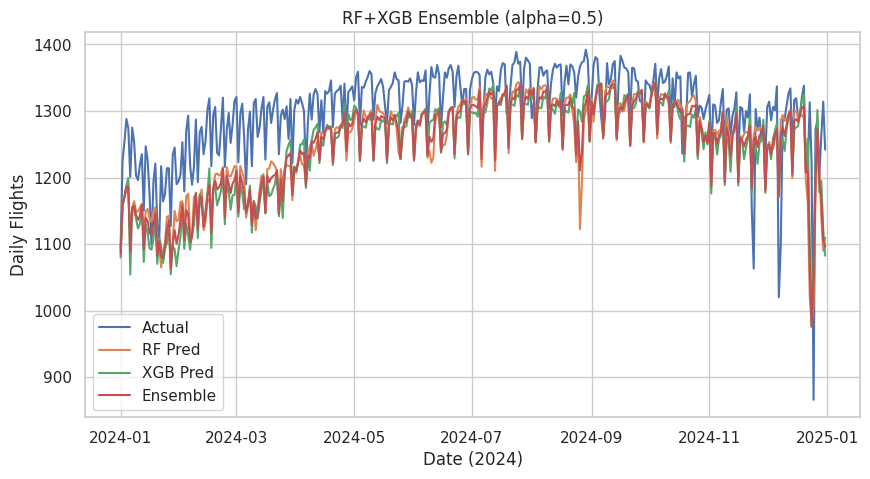

array([1085.55287354, 1158.05148926, 1170.64017578, 1185.55164062,
       1186.24400146, 1087.96537598, 1154.45462646, 1157.87353516,
       1143.80476563, 1136.15124268, 1142.55863037, 1159.49410645,
       1092.99634521, 1139.28536133, 1135.01719971, 1116.32213623,
       1112.58725098, 1128.08799561, 1147.32005371, 1082.23935303,
       1104.16981689, 1080.97165527, 1078.93880371, 1097.08132324,
       1121.36796631, 1135.61295654, 1063.31542236, 1099.59398437,
       1120.92079346, 1100.41794189, 1113.88049072, 1136.86191406,
       1159.93460693, 1105.91395264, 1151.12905029, 1144.34914551,
       1103.95991943, 1112.00246826, 1149.47640869, 1175.75300049,
       1121.19821533, 1171.58158691, 1169.51082031, 1125.6294165 ,
       1142.37649658, 1172.53908447, 1189.25734131, 1116.89392334,
       1183.34121582, 1194.98947266, 1182.10020996, 1185.259729  ,
       1192.33366943, 1213.80316406, 1140.12299805, 1202.6572876 ,
       1190.58011475, 1176.73085205, 1190.89343262, 1195.49720

In [50]:
# alpha=0.5 => simple average
ensemble_rf_xgb(df_cleaned, df_featured, alpha=0.5)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best score (neg RMSE): -335.79577228337655
XGBoost Performance:
  RMSE = 72.39
  MAE  = 61.56
  R^2  = -0.294

Ensemble Weighted alpha=0.7 => RMSE=69.90, MAE=58.50, R^2=-0.206


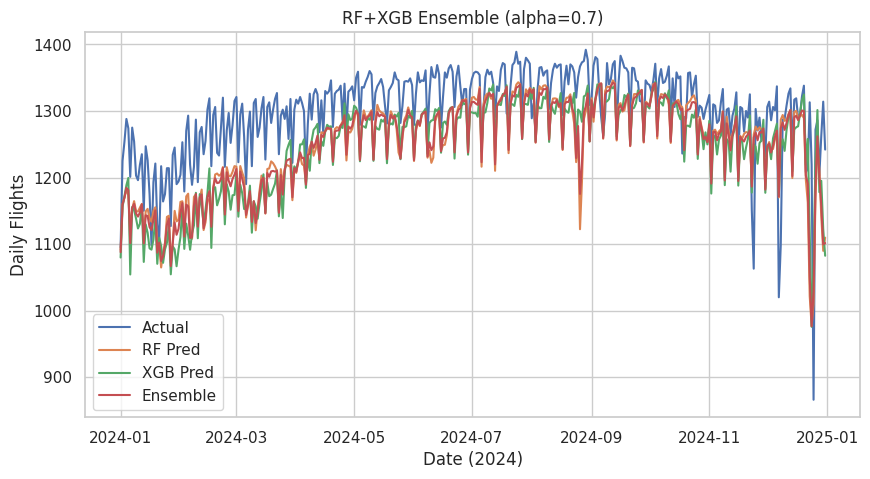

array([1087.86774854, 1158.95090576, 1170.15210547, 1184.42700269,
       1181.01040088, 1101.44325   , 1153.99280029, 1160.52414551,
       1146.01886548, 1141.24276392, 1147.45518433, 1159.82446387,
       1100.94181934, 1143.203229  , 1142.17031982, 1125.44930005,
       1120.976375  , 1136.71680347, 1150.50404443, 1087.01563013,
       1102.03791455, 1074.50300537, 1081.79530664, 1099.12880615,
       1129.13279199, 1138.38377393, 1066.84525952, 1100.76439673,
       1132.48849438, 1113.92276514, 1122.88030664, 1147.43716675,
       1161.68077637, 1111.18838989, 1159.30943018, 1156.88950562,
       1108.95995776, 1110.32949927, 1158.06186963, 1175.2438186 ,
       1126.1909292 , 1170.21297656, 1174.4425105 , 1123.8096499 ,
       1138.64990405, 1170.75545679, 1179.49041699, 1125.98436621,
       1183.9807356 , 1198.8177019 , 1191.66813208, 1192.23585571,
       1197.40822607, 1214.52991675, 1144.31379883, 1207.79439697,
       1195.26808105, 1186.77451123, 1197.93608398, 1204.13833

In [30]:
# alpha=0.7 => 70% random forest
ensemble_rf_xgb(df_cleaned, df_featured, alpha=0.7)

In [23]:
# for stacking

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

def create_train_val_test_splits(df_cleaned_or_featured, airport_code="EGLL",
                                 from_year=2016, use_all_airports=False):
    """
    Splits data into:
      - train: [from_year..2022]
      - val: [2023]
      - test: [2024]
    for either single airport or all airports.
    Returns (data_train, data_val, data_test).
    """
    if use_all_airports:
        data_train = df_cleaned_or_featured[
            (df_cleaned_or_featured["YEAR"] >= from_year) &
            (df_cleaned_or_featured["YEAR"] <= 2022)
        ].copy()
        data_val = df_cleaned_or_featured[df_cleaned_or_featured["YEAR"] == 2023].copy()
        data_test = df_cleaned_or_featured[df_cleaned_or_featured["YEAR"] == 2024].copy()
    else:
        data_train = df_cleaned_or_featured[
            (df_cleaned_or_featured["APT_ICAO"] == airport_code) &
            (df_cleaned_or_featured["YEAR"] >= from_year) &
            (df_cleaned_or_featured["YEAR"] <= 2022)
        ].copy()
        data_val = df_cleaned_or_featured[
            (df_cleaned_or_featured["APT_ICAO"] == airport_code) &
            (df_cleaned_or_featured["YEAR"] == 2023)
        ].copy()
        data_test = df_cleaned_or_featured[
            (df_cleaned_or_featured["APT_ICAO"] == airport_code) &
            (df_cleaned_or_featured["YEAR"] == 2024)
        ].copy()

    data_train.sort_values("FLT_DATE", inplace=True)
    data_val.sort_values("FLT_DATE", inplace=True)
    data_test.sort_values("FLT_DATE", inplace=True)
    return data_train, data_val, data_test

def prep_features_for_rf(df, featured=True):
    """
    If featured=True => drop [FLT_DATE, DailyFlights]
    else => drop [FLT_DATE, FLT_DEP_1, FLT_ARR_1, DailyFlights]
    Then remove any leftover non-numeric columns.
    Returns X (DataFrame) and y (array).
    """
    if featured:
        drop_cols = ["FLT_DATE", "DailyFlights"]
    else:
        drop_cols = ["FLT_DATE", "FLT_DEP_1", "FLT_ARR_1", "DailyFlights"]

    df2 = df.drop(columns=drop_cols, errors="ignore").copy()
    # remove non-numeric
    non_num = df2.select_dtypes(exclude=[np.number]).columns
    df2.drop(columns=non_num, inplace=True)

    y = df["DailyFlights"].values
    return df2, y


def train_predict_rf_egll_2016(df_featured):
    """
    1) Train: [2016..2022], Val: 2023, Test: 2024 for EGLL single-airport
    2) Build & fit RandomForest
    3) Return (y_val, val_pred), (y_test, test_pred), plus the test dates
    """
    data_train, data_val, data_test = create_train_val_test_splits(
        df_featured, airport_code="EGLL", from_year=2016, use_all_airports=False
    )

    # Combine train+val for final fit eventually, but let's keep them separate for the moment
    X_train_df, y_train = prep_features_for_rf(data_train, featured=True)
    X_val_df,   y_val   = prep_features_for_rf(data_val,   featured=True)
    X_test_df,  y_test  = prep_features_for_rf(data_test,  featured=True)

    # Minimal param approach (already "tuned")
    rf = RandomForestRegressor(n_estimators=50, max_depth=None, min_samples_leaf=1,
                               random_state=42)
    rf.fit(X_train_df, y_train)

    val_pred = rf.predict(X_val_df)
    test_pred = rf.predict(X_test_df)

    return (y_val, val_pred), (y_test, test_pred), data_test["FLT_DATE"].values


import xgboost as xgb

def train_predict_xgb_all_2022(df_featured):
    """
    1) Create train: [2022..2022], val: [2023], test: [2024] for ALL airports
       in the training stage.
    2) But for predictions on val/test, we keep only the EGLL rows to match
       the single-airport random forest shape.
    3) Return (y_val_xgb, val_pred_xgb), (y_test_xgb, test_pred_xgb),
       plus test_date array (EGLL only).
    """
    # Step A: basic train/val/test splits
    data_train, data_val, data_test = create_train_val_test_splits(
        df_featured, airport_code="EGLL", from_year=2022, use_all_airports=True
    )
    # Why airport_code="EGLL"? So the function knows how to do the final alignment.
    # We do *all airports* in train, but the function returns a test set that
    # also includes all airports. We'll see below how to handle it.

    # Step B: Train on entire data_train (all airports)
    X_train_df, y_train = prep_features_for_rf(data_train, featured=True)
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train_df.values, y_train)

    # Step C: For val, we still have "data_val" containing all airports in 2023.
    # We'll do predictions for the entire val set, then filter to EGLL.
    X_val_df, y_val_full = prep_features_for_rf(data_val, featured=True)
    val_pred_full = xgb_model.predict(X_val_df.values)

    # Filter the data_val to EGLL only, in the same row order
    data_val_egll = data_val[data_val["APT_ICAO"]=="EGLL"].copy().reset_index(drop=True)
    # We must do a *matching row slice* on X_val_df / val_pred_full for those EGLL rows
    mask_val_egll = (data_val["APT_ICAO"]=="EGLL").values  # Boolean array
    y_val_egll = y_val_full[mask_val_egll]
    val_pred_egll = val_pred_full[mask_val_egll]

    # Step D: Same for test
    X_test_df, y_test_full = prep_features_for_rf(data_test, featured=True)
    test_pred_full = xgb_model.predict(X_test_df.values)

    data_test_egll = data_test[data_test["APT_ICAO"]=="EGLL"].copy().reset_index(drop=True)
    mask_test_egll = (data_test["APT_ICAO"]=="EGLL").values
    y_test_egll = y_test_full[mask_test_egll]
    test_pred_egll = test_pred_full[mask_test_egll]

    # Step E: Return them plus the date array for EGLL only
    test_dates_egll = data_test_egll["FLT_DATE"].values

    # Return matching shapes for stacking
    return (y_val_egll, val_pred_egll), (y_test_egll, test_pred_egll), test_dates_egll



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def stacking_ensemble_last_attempt(df_featured):
    """
    1) Retrieve base-model predictions for validation & test from:
       - RF(EGLL single, from=2016)
       - XGB(all-airport, from=2022) but filtering EGLL in val/test
    2) Weighted averaging approach:
       - search alpha in [0..1] in steps of 0.1 (or finer)
       - pick alpha that yields best val RMSE
       - apply that alpha on test => Weighted ensemble
    3) Stacking approach with a linear meta-learner
    4) Compare both on test, show which is better
    """

    # ----------------------
    # A) Get base-model predictions
    # ----------------------
    (y_val_rf, val_pred_rf), (y_test_rf, test_pred_rf), date_test_rf = train_predict_rf_egll_2016(df_featured)
    (y_val_xgb, val_pred_xgb), (y_test_xgb, test_pred_xgb), date_test_xgb = train_predict_xgb_all_2022(df_featured)

    # Check shapes
    if len(y_val_rf) != len(y_val_xgb) or len(y_test_rf) != len(y_test_xgb):
        print("Val or test shapes differ between RF and XGB. Ensure they match for EGLL only!")
        return

    # For simplicity, assume date_test_rf == date_test_xgb in correct row order
    y_val   = y_val_rf
    y_test  = y_test_rf
    dates_2024 = date_test_rf

    # ----------------------
    # B) Weighted Average Approach
    # ----------------------
    best_alpha = None
    best_rmse_val = float("inf")
    alpha_values = np.linspace(0, 1, 11)  # 0.0, 0.1, ..., 1.0

    for alpha in alpha_values:
        # Weighted val predictions
        val_ens = alpha*val_pred_rf + (1-alpha)*val_pred_xgb
        rmse_val = np.sqrt(mean_squared_error(y_val, val_ens))
        if rmse_val < best_rmse_val:
            best_rmse_val = rmse_val
            best_alpha = alpha

    print(f"\nWeighted Ensemble: Best alpha={best_alpha:.2f} => val RMSE={best_rmse_val:.2f}")

    # Evaluate on test with best_alpha
    test_ens_weighted = best_alpha*test_pred_rf + (1-best_alpha)*test_pred_xgb
    rmse_w = np.sqrt(mean_squared_error(y_test, test_ens_weighted))
    mae_w  = mean_absolute_error(y_test, test_ens_weighted)
    r2_w   = r2_score(y_test, test_ens_weighted)

    print(f"Weighted Ensemble => Test RMSE={rmse_w:.2f}, MAE={mae_w:.2f}, R^2={r2_w:.3f}")

    # ----------------------
    # C) Stacking (Meta-learner)
    # ----------------------
    X_val_stack = np.column_stack([val_pred_rf, val_pred_xgb])
    meta_learner = LinearRegression()
    meta_learner.fit(X_val_stack, y_val)

    X_test_stack = np.column_stack([test_pred_rf, test_pred_xgb])
    test_ens_stack = meta_learner.predict(X_test_stack)

    rmse_s = np.sqrt(mean_squared_error(y_test, test_ens_stack))
    mae_s  = mean_absolute_error(y_test, test_ens_stack)
    r2_s   = r2_score(y_test, test_ens_stack)

    print(f"Stacking => Test RMSE={rmse_s:.2f}, MAE={mae_s:.2f}, R^2={r2_s:.3f}")

    # ----------------------
    # D) Plot final results
    # We'll show all predictions
    # ----------------------
    plt.figure(figsize=(10,5))
    plt.plot(dates_2024, y_test, label="Actual", color="blue")
    plt.plot(dates_2024, test_pred_rf, label="RF Pred", color="red")
    plt.plot(dates_2024, test_pred_xgb, label="XGB Pred", color="green")
    plt.plot(dates_2024, test_ens_weighted, label=f"Weighted α={best_alpha:.2f}", color="orange")
    plt.plot(dates_2024, test_ens_stack, label="Stacked LR", color="purple")
    plt.title("Ensemble (RF+XGB) - Weighted vs. Stacked - EGLL 2024")
    plt.xlabel("Date")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

    # Return dictionary of results
    results = {
        "weighted_ensemble": {
            "alpha": best_alpha,
            "RMSE": rmse_w,
            "MAE": mae_w,
            "R2": r2_w
        },
        "stacking_lr": {
            "RMSE": rmse_s,
            "MAE": mae_s,
            "R2": r2_s
        }
    }
    return results



Weighted Ensemble: Best alpha=0.00 => val RMSE=234.94
Weighted Ensemble => Test RMSE=287.72, MAE=261.33, R^2=-19.436
Stacking => Test RMSE=73.36, MAE=61.29, R^2=-0.328


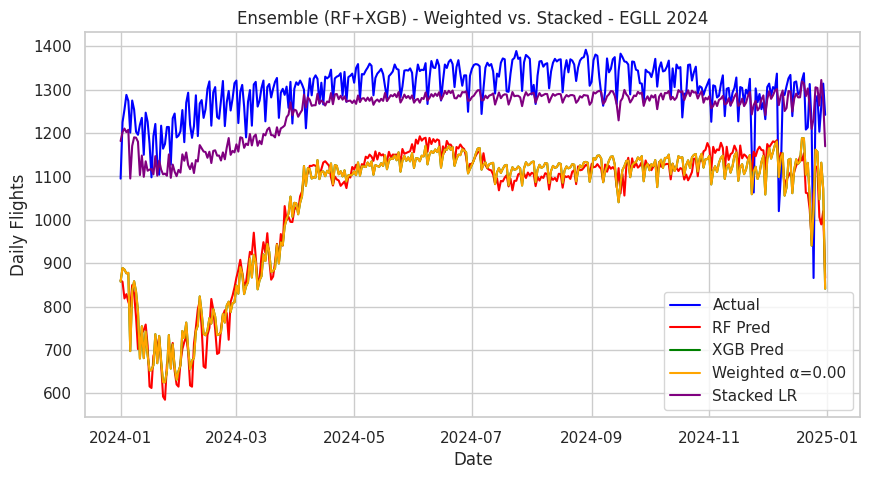

In [34]:
results = stacking_ensemble_last_attempt(df_featured)

Manual moderation

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def apply_perfect_expert_factor(
    y_2023,        # Actual daily flights in 2023 (EGLL)
    y_2024_actual, # Actual daily flights in 2024 (EGLL)
    y_2024_pred,   # Model's original predictions for 2024
):
    """
    Using the real ratio: Sum(2024_actual)/Sum(2023_actual)
    to see how we 'should' scale the model's 2024 predictions
    so the total matches the real 2024 sum.

    Steps:
      1) sum_2023 = sum(y_2023)
      2) sum_2024_actual = sum(y_2024_actual)
      3) real_growth_factor = sum_2024_actual / sum_2023
      4) sum_pred_2024 = sum(y_2024_pred)
      5) scale = sum_2024_actual / sum_pred_2024
      6) y_2024_scaled = y_2024_pred * scale
      7) Evaluate new predictions
    """
    sum_2023 = np.sum(y_2023)
    sum_2024_actual = np.sum(y_2024_actual)
    sum_2024_pred   = np.sum(y_2024_pred)

    # 1) Real total growth
    real_growth_factor = sum_2024_actual / sum_2023

    print(f"Actual 2023 total flights = {sum_2023:.1f}")
    print(f"Actual 2024 total flights = {sum_2024_actual:.1f}")
    print(f"Real growth factor = {real_growth_factor:.4f} (i.e. {((real_growth_factor-1)*100):.1f}%)")

    # 2) Scale factor so that your predicted total matches the actual 2024 total
    if sum_2024_pred == 0:
        scale = 1.0
        print("Warning: model predicted sum is zero - skipping scale.")
    else:
        scale = sum_2024_actual / sum_2024_pred

    y_2024_scaled = y_2024_pred * scale

    # Re-check sums
    scaled_sum_2024 = np.sum(y_2024_scaled)
    print(f"Original predicted sum for 2024 = {sum_2024_pred:.1f}, after scaling => {scaled_sum_2024:.1f}")

    # Evaluate the new daily predictions
    rmse = np.sqrt(mean_squared_error(y_2024_actual, y_2024_scaled))
    mae  = mean_absolute_error(y_2024_actual, y_2024_scaled)
    r2   = r2_score(y_2024_actual, y_2024_scaled)

    print(f"New scaled predictions => RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.3f}")

    return y_2024_scaled, (scale, rmse, mae, r2)

def plot_scaled_predictions(
    dates_2024,
    y_2024_actual,
    y_2024_pred_original,
    y_2024_pred_scaled
):
    """
    Quick plot comparing original vs. scaled predictions vs. actual.
    """
    plt.figure(figsize=(10,5))
    plt.plot(dates_2024, y_2024_actual, label="Actual 2024", color="blue")
    plt.plot(dates_2024, y_2024_pred_original, label="Original Pred", color="red")
    plt.plot(dates_2024, y_2024_pred_scaled, label="Scaled Pred (Perfect Factor)", color="green")
    plt.title("Daily Flight Predictions with Perfect Growth Factor Adjustment")
    plt.xlabel("Date (2024)")
    plt.ylabel("Flights")
    plt.legend()
    plt.show()


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def ensemble_rf_xgb_rev(df_cleaned, df_featured, alpha=0.5, icao="EGLL"):
    """
    1) Get predictions from:
       - RandomForest( single-airport from=2016 ) -> (y_test, y_pred_rf)
       - XGBoost( all-airports from=2022 ) -> (y_test, y_pred_xgb)
    2) Weighted ensemble with alpha.
    3) Evaluate final on y_test (assuming same shape).
    4) Plot Actual vs. Ensemble.
    5) Return (y_test, y_ensemble).
    """

    y_test_rf, y_pred_rf = predict_rf_egll_2016(df_cleaned, df_featured)
    y_test_xgb, y_pred_xgb = predict_xgb_allair_2022(df_cleaned, df_featured)

    # Ensure shapes match
    if len(y_test_rf) != len(y_test_xgb):
        print("Mismatch in test set sizes. Align them by date or data if needed.")
        return None, None

    # We'll consider y_test_rf as the official y_test
    # (if your code truly aligns them, both arrays are identical in content.)
    y_test = y_test_rf

    # Weighted ensemble
    y_pred_ens = alpha * y_pred_rf + (1 - alpha) * y_pred_xgb

    # Evaluate
    rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ens))
    mae_ens  = mean_absolute_error(y_test, y_pred_ens)
    r2_ens   = r2_score(y_test, y_pred_ens)

    print(f"Ensemble Weighted alpha={alpha:.2f} => RMSE={rmse_ens:.2f}, MAE={mae_ens:.2f}, R^2={r2_ens:.3f}")

    # For the test date array, let's just get from df_featured:
    df_temp = df_featured[(df_featured["APT_ICAO"]==icao) & (df_featured["FLT_DATE"].dt.year==2024)]
    date_test = df_temp["FLT_DATE"].values

    plt.figure(figsize=(10,5))
    plt.plot(date_test, y_test, label="Actual", color="blue")
    plt.plot(date_test, y_pred_rf, label="RF Pred", color="red")
    plt.plot(date_test, y_pred_xgb, label="XGB Pred", color="green")
    plt.plot(date_test, y_pred_ens, label="Ensemble", color="orange")
    plt.title(f"RF+XGB Ensemble (alpha={alpha:.2f})")
    plt.xlabel("Date (2024)")
    plt.ylabel("Daily Flights")
    plt.legend()
    plt.show()

    # Return the test actual and ensemble predictions so we can do post-processing
    return y_test, y_pred_ens


In [37]:
def usage_for_perfect_expert_factor(df_cleaned, df_featured):
    """
    Example usage:
    1) Build ensemble predictions on 2024 with alpha=0.7
    2) Grab EGLL 2023 actual => y_2023_egll
    3) Grab EGLL 2024 actual => y_2024_egll_actual
    4) 'apply_perfect_expert_factor(...)' to scale ensemble predictions
    5) Plot
    """
    alpha_value = 0.7

    # (A) Get the ensemble predictions for 2024
    y_test_2024, y_ens_2024 = ensemble_rf_xgb_rev(df_cleaned, df_featured, alpha=alpha_value)
    if y_test_2024 is None or y_ens_2024 is None:
        return  # error case

    # (B) 2023 actual data for EGLL
    df_2023_egll = df_featured[
        (df_featured["APT_ICAO"]=="EGLL") &
        (df_featured["FLT_DATE"].dt.year==2023)
    ].copy()
    y_2023_egll = df_2023_egll["DailyFlights"].values

    # (C) For 2024 actual data, we can use the same array 'y_test_2024'
    #     since the function returns the actual test labels from the XGB/RF alignment
    #     or we can re-pull from df_featured.
    # We'll assume y_test_2024 is the actual daily flights for 2024.
    # If we want the date array:
    df_2024_egll = df_featured[
        (df_featured["APT_ICAO"]=="EGLL") &
        (df_featured["FLT_DATE"].dt.year==2024)
    ].copy()
    date_2024_egll = df_2024_egll["FLT_DATE"].values

    # (D) Now apply "perfect expert factor"
    # We'll assume you have already defined 'apply_perfect_expert_factor':
    y_2024_ens_scaled, (scale, rmse_scaled, mae_scaled, r2_scaled) = apply_perfect_expert_factor(
        y_2023 = y_2023_egll,
        y_2024_actual = y_test_2024,    # since we got from ensemble function
        y_2024_pred = y_ens_2024
    )

    # (E) Plot original vs. scaled
    plot_scaled_predictions(
        dates_2024=date_2024_egll,
        y_2024_actual=y_test_2024,
        y_2024_pred_original=y_ens_2024,
        y_2024_pred_scaled=y_2024_ens_scaled
    )


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best score (neg RMSE): -335.79577228337655
XGBoost Performance:
  RMSE = 72.39
  MAE  = 61.56
  R^2  = -0.294

Ensemble Weighted alpha=0.70 => RMSE=69.90, MAE=58.50, R^2=-0.206


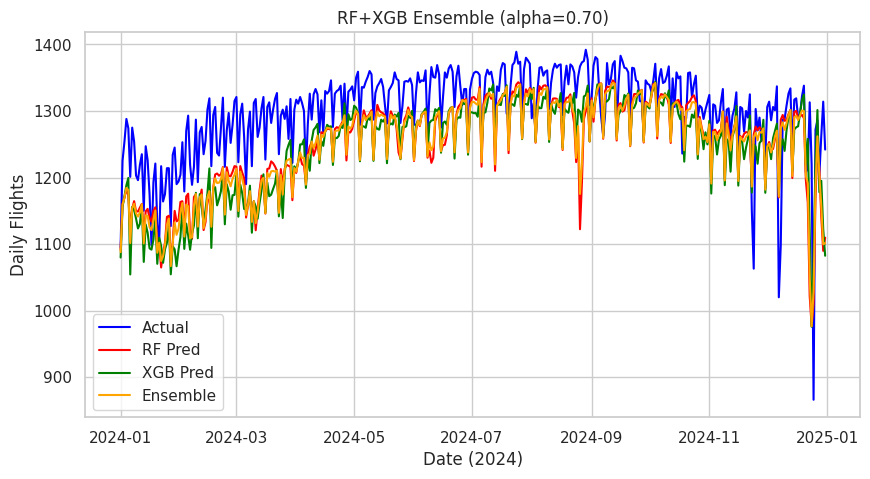

Actual 2023 total flights = 456739.0
Actual 2024 total flights = 476359.0
Real growth factor = 1.0430 (i.e. 4.3%)
Original predicted sum for 2024 = 457107.2, after scaling => 476359.0
New scaled predictions => RMSE=47.43, MAE=31.66, R^2=0.445


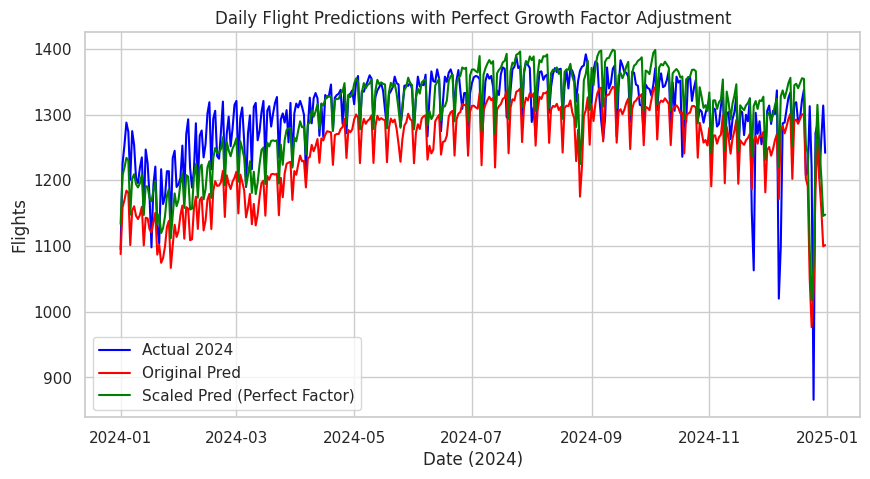

In [38]:
usage_for_perfect_expert_factor(df_cleaned, df_featured)